# 0. Dependencies and Data

In [2]:
! pip install vaderSentiment
! pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00


In [1]:
!pip install numpy==1.26.4 gensim==4.3.2 scipy==1.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 35.2 MB/s eta 0:00:00
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user


In [1]:
# Imports
from google.colab import drive
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import seaborn as sns
import matplotlib.cm as cm
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the data
file_path = '/content/drive/MyDrive/DLSS Project/eda_data.json'

df = pd.read_json(file_path, lines=False)
df.head()

title                      artist  \
0              All I Want For Christmas Is You                Mariah Carey   
1  The Christmas Song (Merry Christmas To You)             Nat "King" Cole   
2                                  The Weekend                         SZA   
3                                     No Smoke  YoungBoy Never Broke Again   
4                                    New Rules                    Dua Lipa   

   genius_id language primary_tag  \
0     204233       en         r&b   
1    1717793       en         pop   
2    3113598       en         r&b   
3    3183597       en         rap   
4    3013669       en  electronic   

                                                tags  \
0  [R&B, Pop, USA, In English, Soul Pop, Soul, Po...   
1  [Pop, Big Band, Swing, Jazz, Acoustic, Holiday...   
2  [R&B, USA, In English, Psychedelic Soul, Neo S...   
3                           [Rap, Dirty South, Trap]   
4  [Electronic, Pop, EDM, In English, UK Pop, Dan...   

                                          genius_url release_date  \
0  https://genius.com/Mariah-carey-all-i-want-for...   1994-10-29   
1  https://genius.com/The-nat-king-cole-trio-the-...         None   
2          https://genius.com/Sza-the-weekend-lyrics   2017-09-26   
3  https://genius.com/Youngboy-never-broke-again-...   2017-08-03   
4       https://genius.com/Dua-lipa-new-rules-lyrics   2017-06-02   

                                               album  \
0                                      Greatest Hits   
1  The Complete Capitol Recordings of The Nat Kin...   
2                                      Ctrl (Deluxe)   
3                                        AI YoungBoy   
4                   Dua Lipa (Japan Special Edition)   

                                              lyrics  \
0  185 Contributors\nTranslations\nEspañol\nTürkç...   
1  8 Contributors\nThe Christmas Song (Merry Chri...   
2  140 Contributors\nTranslations\nTürkçe\nEspaño...   
3  53 Contributors\nTranslations\nFrançais\nNo Sm...   
4  230 Contributors\nTranslations\nEspañol\nPortu...   

                                        lyrics_clean     chart_date  rank  \
0  want lot christmas one thing need care present...  1515196800000    13   
1  chestnuts roasting open fire jack frost nippin...  1515196800000    42   
2  mood right mood say got girl want want got gir...  1515196800000    33   
3  dj chose bro bro nigga homie count money fuck ...  1515196800000    77   
4  one talkin sleep night makin crazy wrote read ...  1515196800000    12   

   peak     peak_date  
0   1.0  1.576886e+12  
1   9.0  1.673050e+12  
2   NaN           NaN  
3  61.0  1.517616e+12  
4   6.0  1.518826e+12

In [4]:
# Correcting the date format after opening the json file
df["chart_date"] = pd.to_datetime(df["chart_date"], unit="ms", errors="coerce")
df["chart_date"] = df["chart_date"].dt.strftime("%Y-%m-%d")

df["peak_date"] = pd.to_datetime(df["peak_date"], unit='ms')
df.head()

title                      artist  \
0              All I Want For Christmas Is You                Mariah Carey   
1  The Christmas Song (Merry Christmas To You)             Nat "King" Cole   
2                                  The Weekend                         SZA   
3                                     No Smoke  YoungBoy Never Broke Again   
4                                    New Rules                    Dua Lipa   

   genius_id language primary_tag  \
0     204233       en         r&b   
1    1717793       en         pop   
2    3113598       en         r&b   
3    3183597       en         rap   
4    3013669       en  electronic   

                                                tags  \
0  [R&B, Pop, USA, In English, Soul Pop, Soul, Po...   
1  [Pop, Big Band, Swing, Jazz, Acoustic, Holiday...   
2  [R&B, USA, In English, Psychedelic Soul, Neo S...   
3                           [Rap, Dirty South, Trap]   
4  [Electronic, Pop, EDM, In English, UK Pop, Dan...   

                                          genius_url release_date  \
0  https://genius.com/Mariah-carey-all-i-want-for...   1994-10-29   
1  https://genius.com/The-nat-king-cole-trio-the-...         None   
2          https://genius.com/Sza-the-weekend-lyrics   2017-09-26   
3  https://genius.com/Youngboy-never-broke-again-...   2017-08-03   
4       https://genius.com/Dua-lipa-new-rules-lyrics   2017-06-02   

                                               album  \
0                                      Greatest Hits   
1  The Complete Capitol Recordings of The Nat Kin...   
2                                      Ctrl (Deluxe)   
3                                        AI YoungBoy   
4                   Dua Lipa (Japan Special Edition)   

                                              lyrics  \
0  185 Contributors\nTranslations\nEspañol\nTürkç...   
1  8 Contributors\nThe Christmas Song (Merry Chri...   
2  140 Contributors\nTranslations\nTürkçe\nEspaño...   
3  53 Contributors\nTranslations\nFrançais\nNo Sm...   
4  230 Contributors\nTranslations\nEspañol\nPortu...   

                                        lyrics_clean  chart_date  rank  peak  \
0  want lot christmas one thing need care present...  2018-01-06    13   1.0   
1  chestnuts roasting open fire jack frost nippin...  2018-01-06    42   9.0   
2  mood right mood say got girl want want got gir...  2018-01-06    33   NaN   
3  dj chose bro bro nigga homie count money fuck ...  2018-01-06    77  61.0   
4  one talkin sleep night makin crazy wrote read ...  2018-01-06    12   6.0   

   peak_date  
0 2019-12-21  
1 2023-01-07  
2        NaT  
3 2018-02-03  
4 2018-02-17

Prepare the data for the exploratory analysis:

In [5]:
# Remove songs from genres with less then 100 songs associated with
genres_to_keep = ['pop', 'country', 'rap', 'r&b', 'electronic', 'rock']
df = df[df['primary_tag'].isin(genres_to_keep)]

# Add relevant time columns
df['year'] = pd.to_datetime(df['chart_date']).dt.year
df['month'] = pd.to_datetime(df["chart_date"]).dt.to_period("M")
df['month_ts'] = df['month'].dt.to_timestamp()

# Remove columns that are not needed
df = df.drop(columns=['language', 'genius_url', 'lyrics'])
df.head()

title                      artist  \
0              All I Want For Christmas Is You                Mariah Carey   
1  The Christmas Song (Merry Christmas To You)             Nat "King" Cole   
2                                  The Weekend                         SZA   
3                                     No Smoke  YoungBoy Never Broke Again   
4                                    New Rules                    Dua Lipa   

   genius_id primary_tag                                               tags  \
0     204233         r&b  [R&B, Pop, USA, In English, Soul Pop, Soul, Po...   
1    1717793         pop  [Pop, Big Band, Swing, Jazz, Acoustic, Holiday...   
2    3113598         r&b  [R&B, USA, In English, Psychedelic Soul, Neo S...   
3    3183597         rap                           [Rap, Dirty South, Trap]   
4    3013669  electronic  [Electronic, Pop, EDM, In English, UK Pop, Dan...   

  release_date                                              album  \
0   1994-10-29                                      Greatest Hits   
1         None  The Complete Capitol Recordings of The Nat Kin...   
2   2017-09-26                                      Ctrl (Deluxe)   
3   2017-08-03                                        AI YoungBoy   
4   2017-06-02                   Dua Lipa (Japan Special Edition)   

                                        lyrics_clean  chart_date  rank  peak  \
0  want lot christmas one thing need care present...  2018-01-06    13   1.0   
1  chestnuts roasting open fire jack frost nippin...  2018-01-06    42   9.0   
2  mood right mood say got girl want want got gir...  2018-01-06    33   NaN   
3  dj chose bro bro nigga homie count money fuck ...  2018-01-06    77  61.0   
4  one talkin sleep night makin crazy wrote read ...  2018-01-06    12   6.0   

   peak_date  year    month   month_ts  
0 2019-12-21  2018  2018-01 2018-01-01  
1 2023-01-07  2018  2018-01 2018-01-01  
2        NaT  2018  2018-01 2018-01-01  
3 2018-02-03  2018  2018-01 2018-01-01  
4 2018-02-17  2018  2018-01 2018-01-01

# 1. EDA - Basic Statistics

In [6]:
print('Time period from:', df['chart_date'].min(), 'to', df['chart_date'].max(), '\n')
print('Number of songs analyzed:', len(df), '\n')
print('Number of artist:', df['artist'].nunique(), '\n')
print('Top 10 artists:', df['artist'].value_counts().head(20), '\n')
print('Genres:', df['primary_tag'].unique())

Time period from: 2018-01-06 to 2024-12-28 

Number of songs analyzed: 26636 

Number of artist: 1094 

Top 10 artists: artist
Taylor Swift                  760
Morgan Wallen                 735
Luke Combs                    472
Billie Eilish                 442
Drake                         380
Ariana Grande                 351
Dua Lipa                      333
Olivia Rodrigo                322
Lil Baby                      322
SZA                           318
Post Malone                   304
Doja Cat                      289
Rod Wave                      251
Harry Styles                  247
Juice WRLD                    230
The Weeknd                    227
Sabrina Carpenter             211
YoungBoy Never Broke Again    207
Zach Bryan                    206
Kane Brown                    192
Name: count, dtype: int64 

Genres: ['r&b' 'pop' 'rap' 'electronic' 'country' 'rock']


# 2. EDA - Genre distributions and temporal evolution patterns

Average number of songs to analyze per year: 3805.0


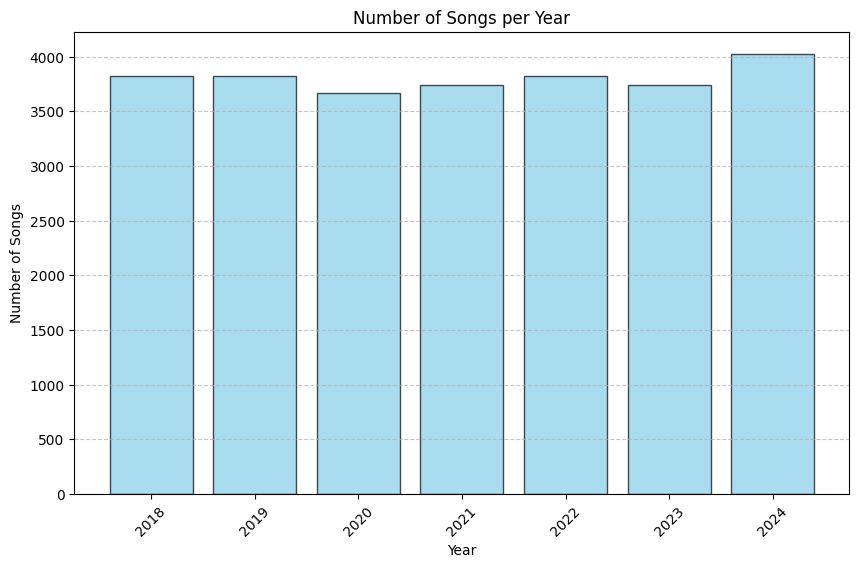

In [7]:
# Compute the number of songs released by year
year_counts = df['year'].value_counts().sort_index()
print('Average number of songs to analyze per year:', year_counts.mean().round())

# Plot a bar chart for visualization
plt.figure(figsize=(10, 6))
plt.bar(year_counts.index, year_counts.values, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.title("Number of Songs per Year")
plt.xticks(year_counts.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Note: The average number of songs that we analyze pe year is lower than expected (5200 since we analyze the 100 top-songs for every 52 weeks of the year). This can be explained by removing non-english songs, as well as excluding rare genres and non-music entries in the Genius API.

**Explore genre distribution:**

primary_tag
pop           6684
country       6138
rap           5958
r&b           3904
electronic    2104
rock          1848
Name: count, dtype: int64
primary_tag
pop           25.093858
country       23.044001
rap           22.368223
r&b           14.656855
electronic     7.899084
rock           6.937979
Name: count, dtype: float64


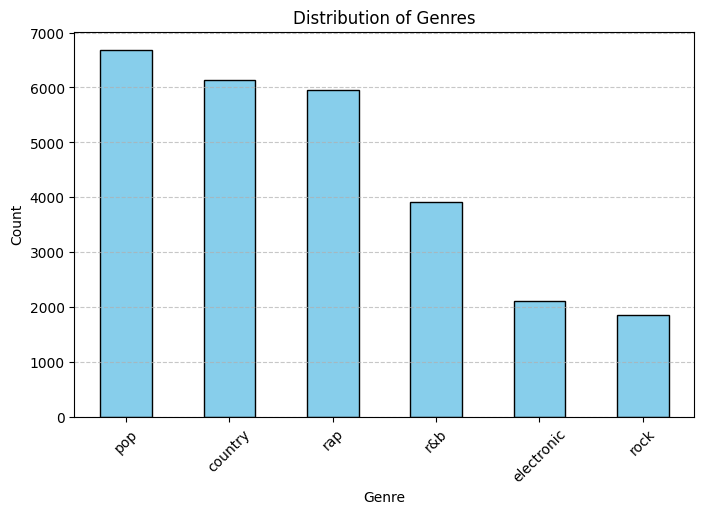

In [8]:
# Compute the number of songs released by genre
genre_counts = df['primary_tag'].value_counts()
print(genre_counts)

genre_counts_percentage = (genre_counts / genre_counts.sum()) * 100
print(genre_counts_percentage)

# Plot the bar chart
plt.figure(figsize=(8, 5))
genre_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Distribution of Genres")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

primary_tag  country  electronic   pop   r&b   rap  rock
year                                                    
2018            0.16        0.10  0.22  0.19  0.27  0.05
2019            0.20        0.08  0.26  0.17  0.26  0.04
2020            0.19        0.06  0.27  0.15  0.26  0.06
2021            0.25        0.08  0.25  0.14  0.23  0.06
2022            0.25        0.09  0.24  0.12  0.23  0.07
2023            0.31        0.06  0.24  0.13  0.15  0.12
2024            0.26        0.09  0.28  0.13  0.17  0.08


<Figure size 1200x600 with 0 Axes>

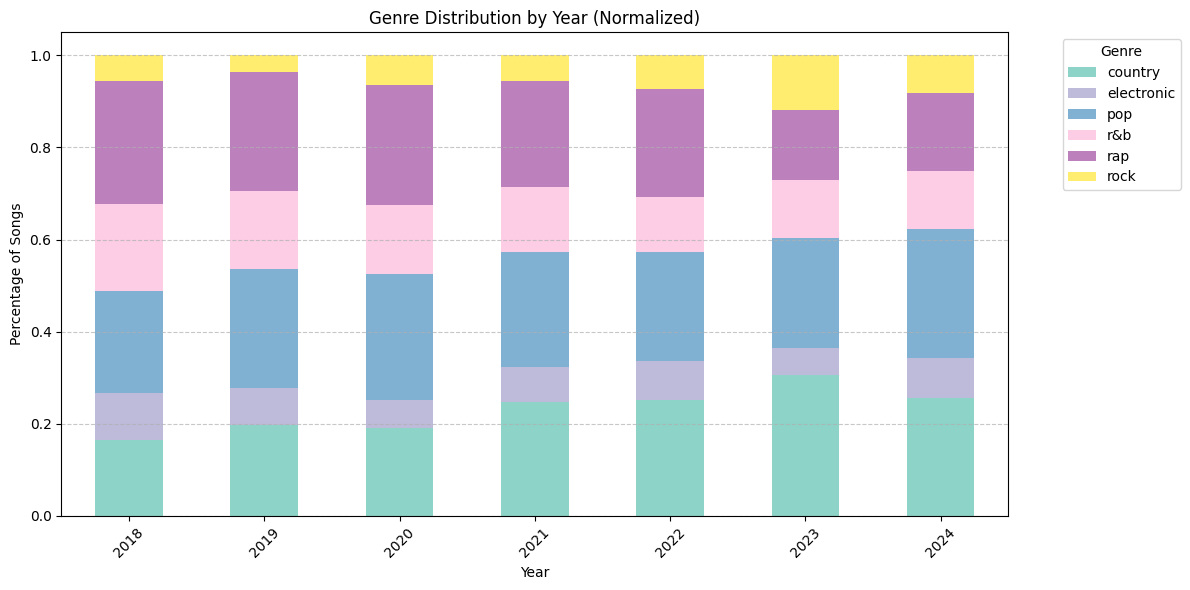

In [9]:
# Compute the number of songs released by genre by year
genre_by_year = df.groupby(['year', 'primary_tag']).size().unstack(fill_value=0)

# Normalize: convert counts to percentages per year
genre_by_year_percent = genre_by_year.div(genre_by_year.sum(axis=1), axis=0)
print(genre_by_year_percent.round(2))

# Plot normalized data as a stacked bar chart
plt.figure(figsize=(12, 6))
genre_by_year_percent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set3')

plt.xlabel("Year")
plt.ylabel("Percentage of Songs")
plt.title("Genre Distribution by Year (Normalized)")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [10]:
# Visualize genre distribution as Pie Charts

df_pies = df.groupby(['year', 'primary_tag'], observed = True).size().reset_index(name='count')

# Get sorted list of bins
bins_sorted = df_pies['year'].dropna().unique().tolist()
bins_sorted.sort()

# Visualization
fig = make_subplots(rows=3, cols=3,
                    specs=[[{'type':'domain'} for _ in range(3)] for _ in range(3)])

for idx, bin_label in enumerate(bins_sorted):
    row = idx // 3 + 1
    col = idx % 3 + 1
    data_bin = df_pies[df_pies['year'] == bin_label]

    # Add pie chart
    fig.add_trace(
        go.Pie(
            labels=data_bin['primary_tag'],
            values=data_bin['count'],
            name=str(bin_label)),
        row=row, col=col)

    # Add annotation
    fig.add_annotation(
        text=str(bin_label),
        x=col * 0.32 - 0.17,
        y=1 - (row - 1) * 0.32 + 0.03,
        font_size=10,
        showarrow=False)

fig.update_traces(hole=0.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Genre Distribution by Year",
    height=800)
fig.show()

**Explore evolution of genre distribution over time:**

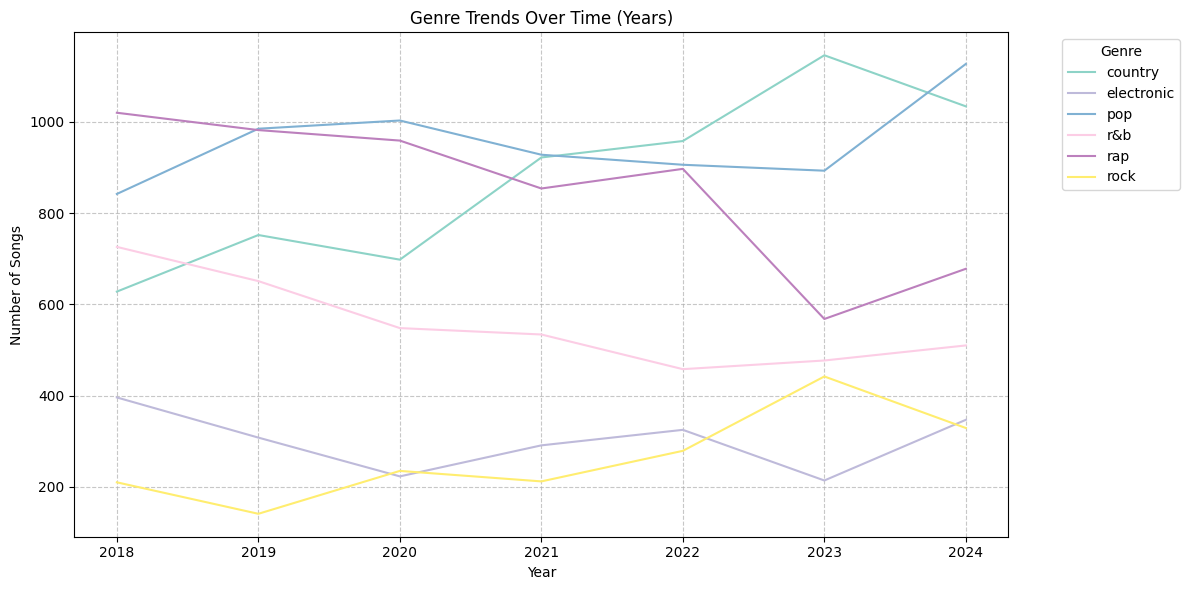

In [11]:
# Plot the evolution of genre distibution from 2018-2024
plt.figure(figsize=(12, 6))

cmap = plt.get_cmap('Set3')
colors = cmap(np.linspace(0, 1, len(genre_by_year.columns)))

for i, genre in enumerate(genre_by_year.columns):
    plt.plot(genre_by_year.index, genre_by_year[genre], label=genre, color=colors[i])

plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.title("Genre Trends Over Time (Years)")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

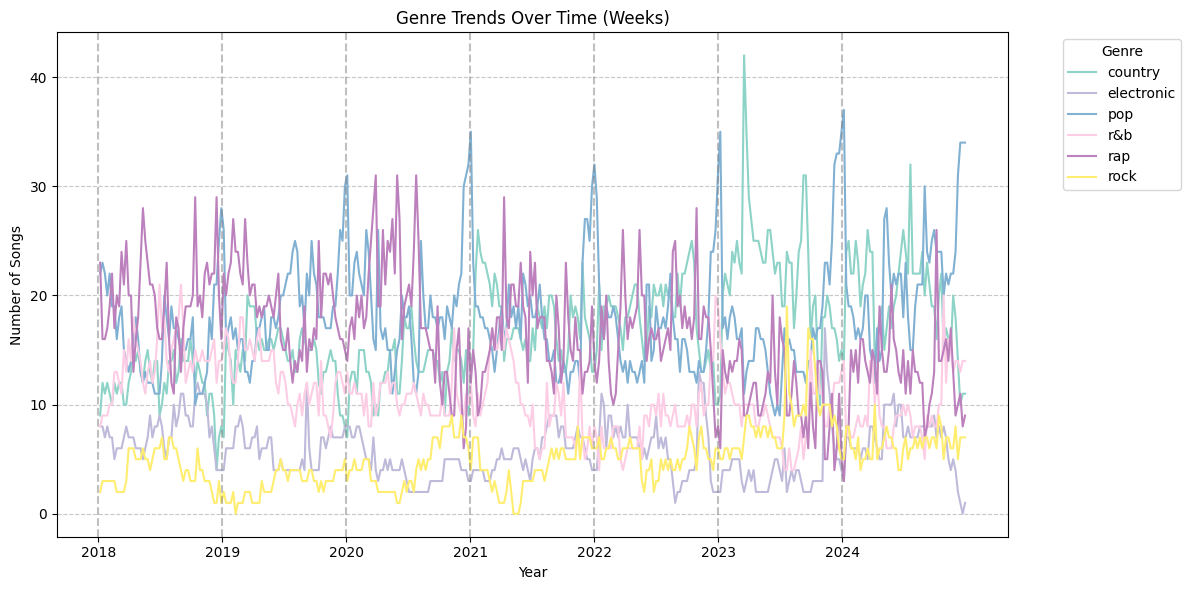

In [12]:
# Plot the weekly evolution of genre distibution from 2018-2024

# Group the data by week and genre
genre_by_weeks = df.groupby(['chart_date', 'primary_tag']).size().unstack(fill_value=0)
genre_by_weeks.index = pd.to_datetime(genre_by_weeks.index)

# Visualization
plt.figure(figsize=(12, 6))

cmap = plt.get_cmap('Set3')
colors = cmap(np.linspace(0, 1, len(genre_by_year.columns)))

for i, genre in enumerate(genre_by_weeks.columns):
    plt.plot(genre_by_weeks.index, genre_by_weeks[genre], label=genre, color=colors[i])

years = pd.to_datetime(sorted(genre_by_weeks.index.year.unique()), format='%Y')
plt.xticks(years, [y.year for y in years])

# Add in vertical lines each year for improved interpretability
for year in years:
    plt.axvline(x=year, color='gray', linestyle='--', alpha=0.5)

plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.title("Genre Trends Over Time (Weeks)")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis = 'y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

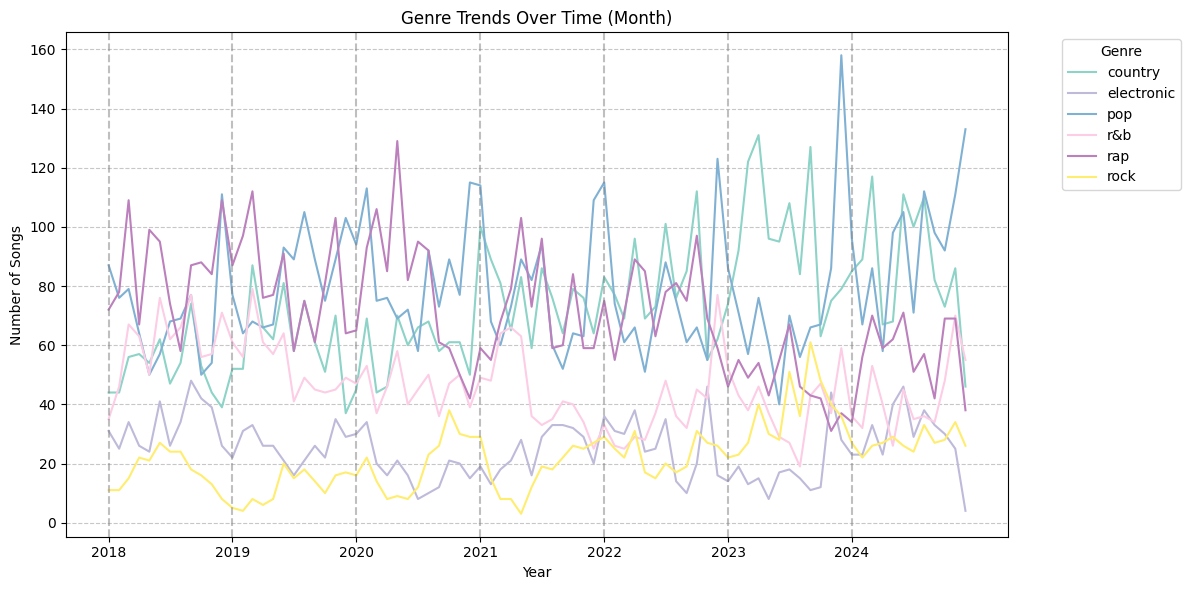

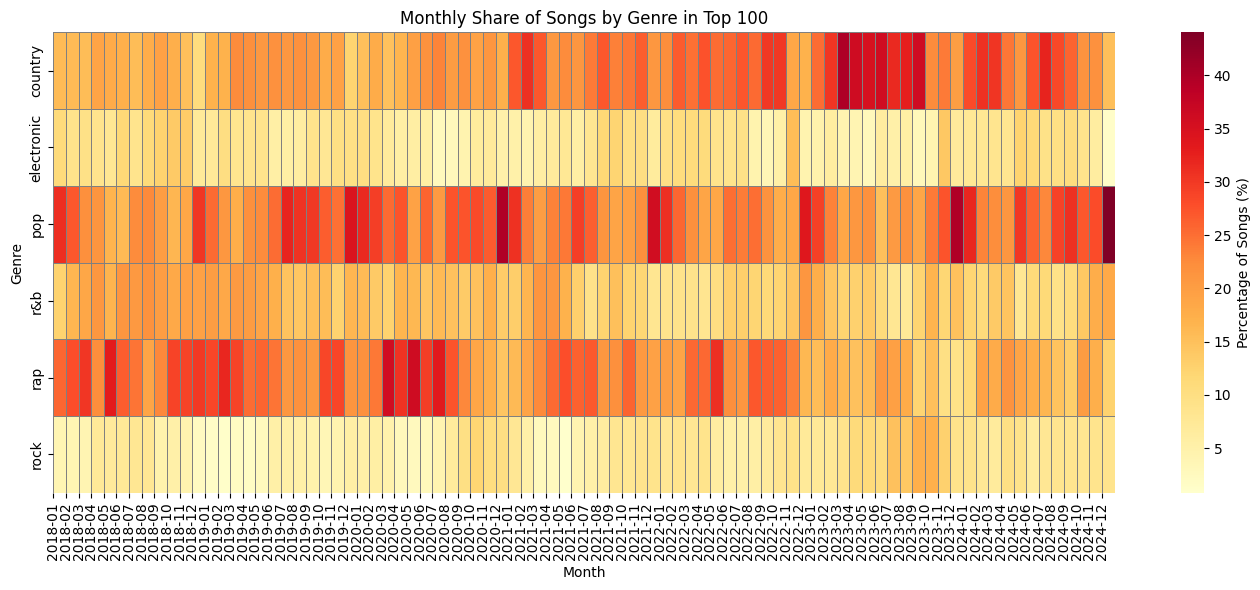

In [21]:
# Plot the monthly evolution of genre distibution from 2018-2024

# Group the data by month and genre
genre_by_month = df.groupby(['month', 'primary_tag']).size().unstack(fill_value=0)
genre_by_month.index = genre_by_month.index.to_timestamp()

# Visualization (line plot)
plt.figure(figsize=(12, 6))

cmap = plt.get_cmap('Set3')
colors = cmap(np.linspace(0, 1, len(genre_by_month.columns)))

for i, genre in enumerate(genre_by_month.columns):
    plt.plot(genre_by_month.index, genre_by_month[genre], label=genre, color=colors[i])

# Add in vertical lines each year for improved interpretability
years = pd.to_datetime(sorted(genre_by_month.index.year.unique()), format='%Y')
plt.xticks(years, [y.year for y in years])
for year in years:
    plt.axvline(x=year, color='gray', linestyle='--', alpha=0.5)

plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.title("Genre Trends Over Time (Month)")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Visualization (heatmap)

# Compute monthly percentages
genre_by_month_pct = genre_by_month.div(genre_by_month.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 6))
sns.heatmap(
    genre_by_month_pct.T,  # transpose to have genres on y-axis
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Percentage of Songs (%)'})

ax = plt.gca()
ax.set_xticks(range(len(genre_by_month_pct.index)))
ax.set_xticklabels([d.strftime('%Y-%m') for d in genre_by_month_pct.index])


plt.title('Monthly Share of Songs by Genre in Top 100')
plt.xlabel('Month')
plt.ylabel('Genre')

plt.tight_layout()
plt.show()

**Analysis of song-length:**

Average song length (in words): 181.51


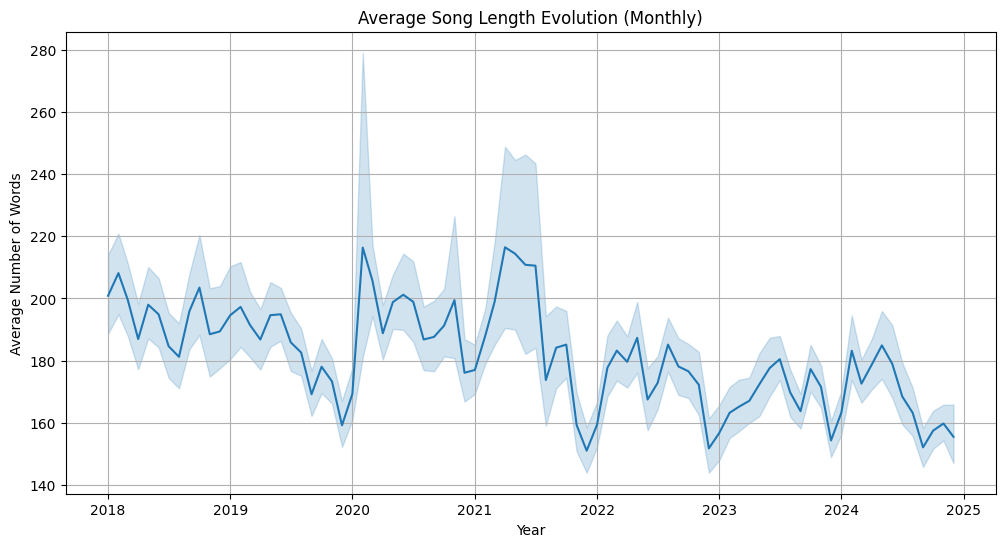

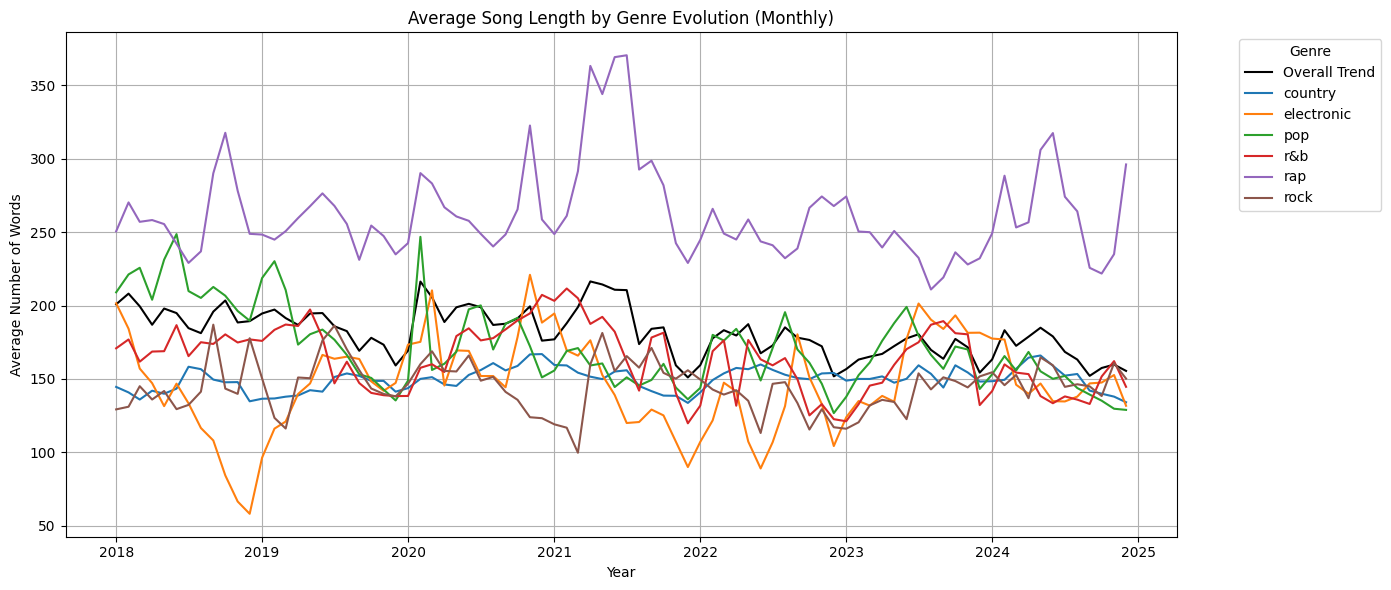

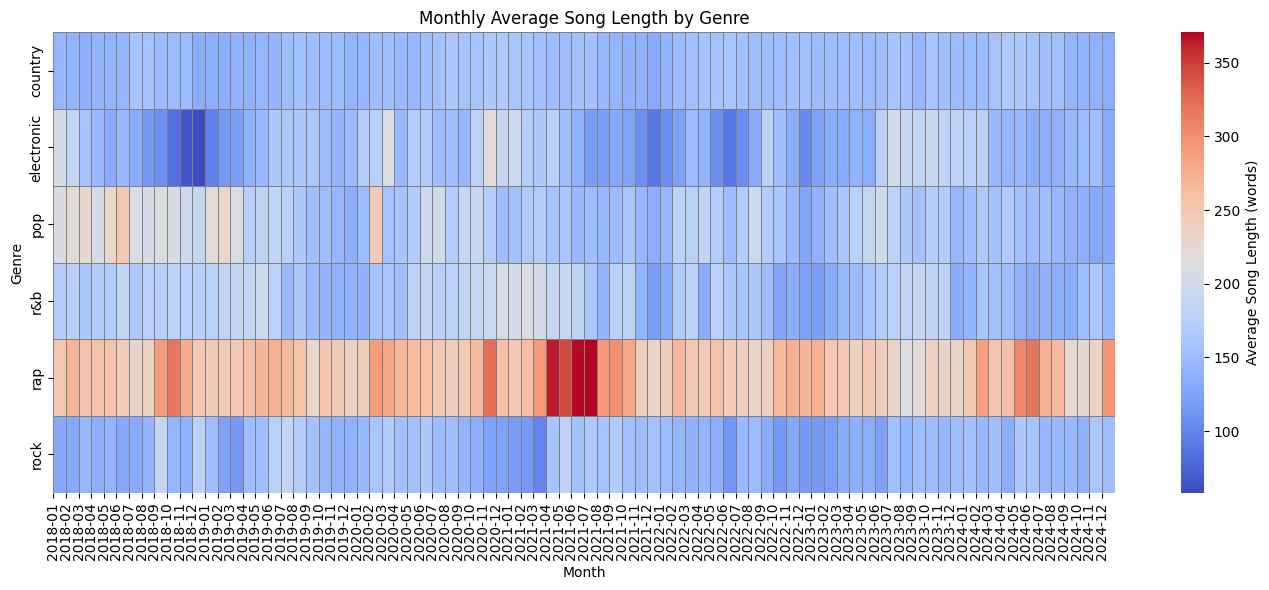

In [28]:
# Surpress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

#NÖTIG?
df['chart_date'] = pd.to_datetime(df['chart_date'])
df['month'] = df['chart_date'].dt.to_period('M').dt.to_timestamp()

# Compute number of words per song
df['song_length'] = df['lyrics_clean'].apply(lambda x: len(x.split()))

# Compute average song length over all songs
overall_avg_length = df['song_length'].mean()
print(f"Average song length (in words): {overall_avg_length:.2f}")

# Plot evolution in song-length over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='month', y='song_length', estimator='mean')
plt.title("Average Song Length Evolution (Monthly)")
plt.ylabel("Average Number of Words")
plt.xlabel("Year")
plt.grid(True)
plt.show()




# Compute monthly average song length per genre
avg_song_length_evolution = df.groupby(['month', 'primary_tag'])['song_length'].mean().reset_index()


# Plot evolution in song-length over time by genre
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='month', y='song_length', estimator='mean', errorbar=None, color='black', label='Overall Trend')

sns.lineplot(data=avg_song_length_evolution, x='month', y='song_length', hue='primary_tag')
plt.title("Average Song Length by Genre Evolution (Monthly)")
plt.ylabel("Average Number of Words")
plt.xlabel("Year")
plt.grid(True)
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# Visualize evaluation in song-length over time by gerne with a heatmap for easier interpretation
song_length_heatmap = avg_song_length_evolution.pivot(index='primary_tag', columns='month', values='song_length')

plt.figure(figsize=(14, 6))
sns.heatmap(
    song_length_heatmap,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Average Song Length (words)'})

ax = plt.gca()
ax.set_xticks(range(len(song_length_heatmap.columns)))
ax.set_xticklabels([d.strftime('%Y-%m') for d in song_length_heatmap.columns])

plt.title('Monthly Average Song Length by Genre')
plt.xlabel('Month')
plt.ylabel('Genre')

plt.tight_layout()
plt.show()

In [23]:
# Compute the avarge song length by genre (covering the whole observation period)
avg_length_by_genre = df.groupby('primary_tag')['song_length'].mean().reset_index().round()
avg_length_by_genre

primary_tag  song_length
0     country        150.0
1  electronic        142.0
2         pop        169.0
3         r&b        165.0
4         rap        264.0
5        rock        144.0

In [24]:
# Compute average song length by year
avg_length_by_year = df.groupby('year')['song_length'].mean().reset_index().round()
avg_length_by_year

year  song_length
0  2018        194.0
1  2019        184.0
2  2020        194.0
3  2021        190.0
4  2022        174.0
5  2023        168.0
6  2024        168.0

# 3. EDA - Cultural trend exploration & Sentiment Analysis

**Wordcloud analysis:**

In [8]:
# Define Stopwords for wordclouds
custom_stopwords = set(STOPWORDS)

# Add common words often not meaningful in lyrics
custom_stopwords.update([
    'oh', 'yeah', 'la', 'na', 'got', 'know', "ain't",
    'uh', 'ooh', 'hey', 'come', 'let', 'go', 'get', 's',
    'im', 'dont', 'youre', 'cant', 'aint', 'will', 'one',
    'now', 'cause', 'wanna', 'make', 'take', 'said', 'em',
    'want', 'mm', 'tell', 'eh', 'u', 'woah', 'ya', 'bout',
    'gonna', 'doo', 'say', 'never', 'need', 'ayy', 'ho', 'way',
    'give', 'da', 'tryna'
])

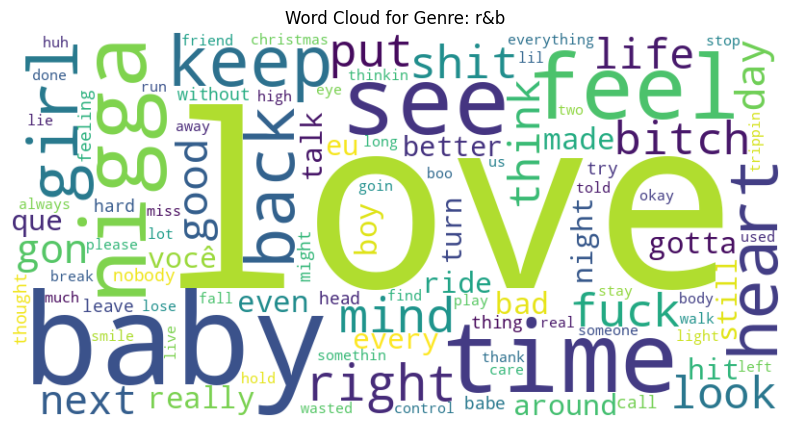

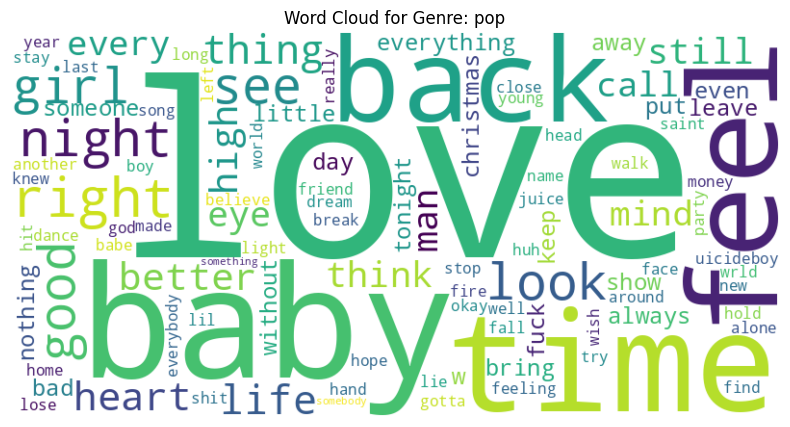

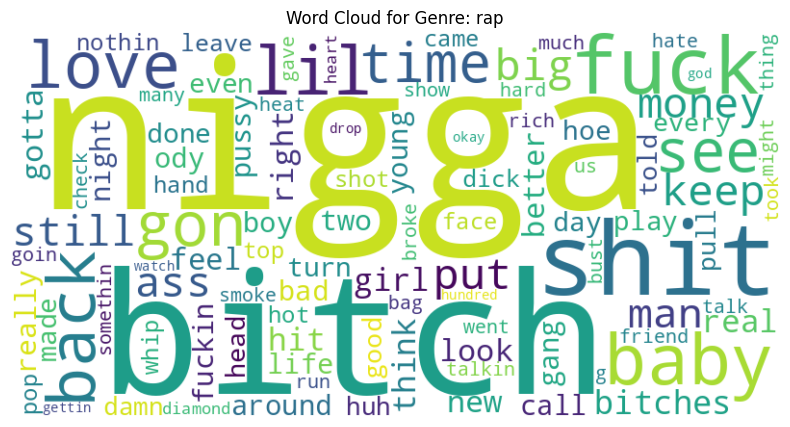

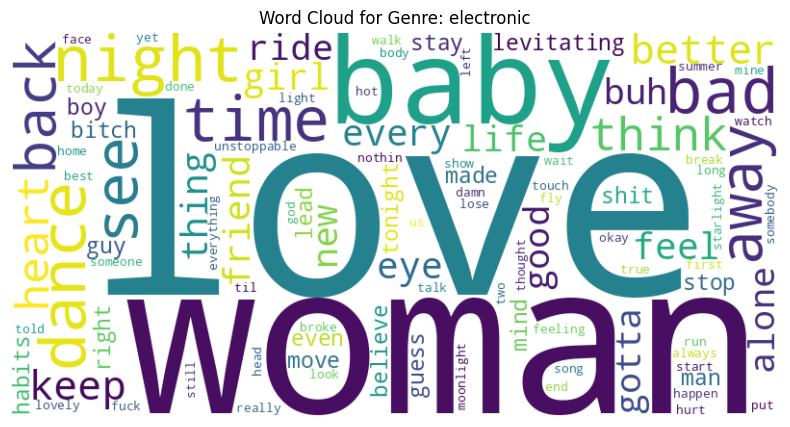

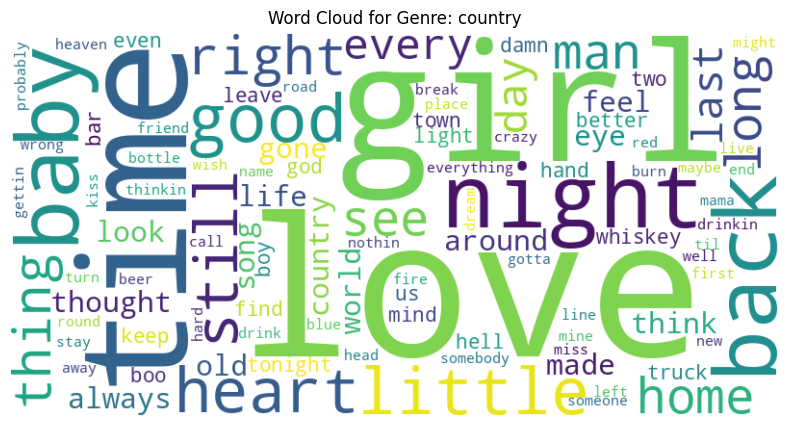

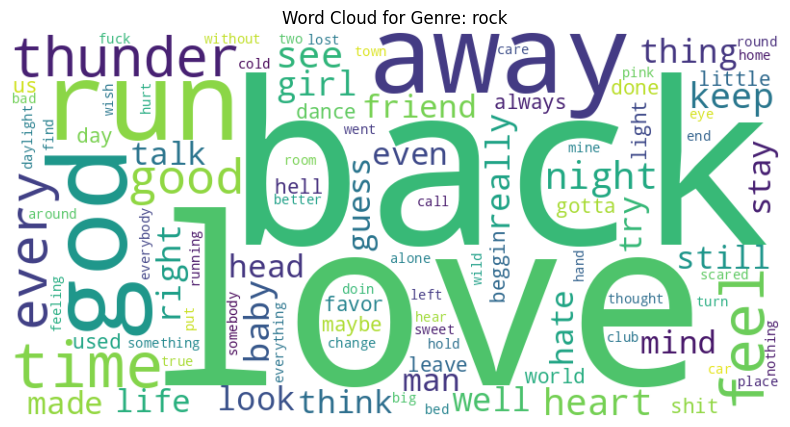

In [9]:
# Generate wordclouds per genre

# Get unique genres
genres = df['primary_tag'].unique()

# Loop over all genrers
for genre in genres:

    # Combine all cleaned lyrics per genre into one text
    text = ' '.join(df[df['primary_tag'] == genre]['lyrics_clean'].dropna())

    # Create the word cloud
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=custom_stopwords,
        collocations=False,
        max_words=100
    ).generate(text)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Genre: {genre}")
    plt.show()

In [10]:
# Generate one wordcloud per genre and year

# Create a reusable function for generating the wordclouds
def plot_wordclouds_per_genre(df, genre, years, labels):

    # Filter data for genre
    genre_data = df[df['primary_tag'] == genre]
    n_bins = len(labels)

    # Determine grid size
    ncols = 2
    nrows = (n_bins + 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows*6))
    axs = axs.flatten()

    for i, year in enumerate(labels):
        subset = genre_data[genre_data['year'] == year]

        if subset.empty:
            axs[i].axis('off')
            axs[i].set_title(f"{year}\nNo data")
            continue

        text = ' '.join(subset['lyrics_clean'].dropna())
        if not text.strip():
            axs[i].axis('off')
            axs[i].set_title(f"{year}\nNo text")
            continue

        wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            stopwords=custom_stopwords,
            collocations=False,
            max_words=100
        ).generate(text)

        axs[i].imshow(wordcloud, interpolation='bilinear')
        axs[i].axis('off')
        axs[i].set_title(f"Year: {year}")

    # Hide any unused subplots
    for j in range(i+1, len(axs)):
        axs[j].axis('off')

    plt.suptitle(f"Word Clouds for Genre: {genre}", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

years = np.arange(2018, 2025, 1)
#print(years)

for genre in genres:
    plot_wordclouds_per_genre(df, genre=genre, years=years, labels=years)

In [11]:
years = np.arange(2018, 2025, 1)
print(years)

for genre in genres:
    plot_wordclouds_per_genre(df, genre=genre, years=years, labels=years)

Output hidden; open in https://colab.research.google.com to view.

**Sentiment Analysis:**

In [29]:
# Instantiate sentiment analyzer
VADER_analyzer = SentimentIntensityAnalyzer()

# Create a new dataframe for the sentiment analysis
df_sentiment = df.copy()

# Run sentiment analysis and safe the compound score for each song
compound_scores = []

for lyrics in df_sentiment['lyrics_clean']:
    classification = VADER_analyzer.polarity_scores(lyrics)
    compound_scores.append(float(classification['compound']))


df_sentiment['VADER_compound'] = compound_scores

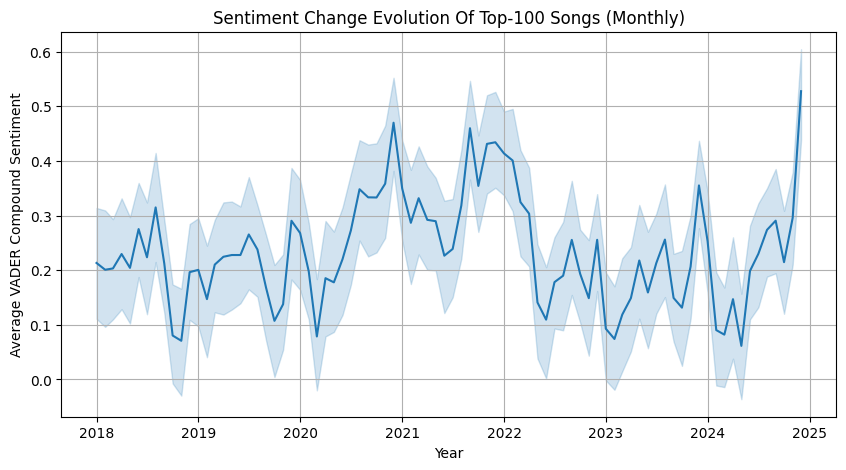

In [31]:
# Visualize VADER sentiment development from 2014-2018

#df_sentiment['date'] = pd.to_datetime(df['chart_date'])
#df_sentiment['month'] = df_sentiment['date'].dt.to_period('M').dt.to_timestamp()

plt.figure(figsize=(10,5))
sns.lineplot(data=df_sentiment, x='month_ts', y='VADER_compound', estimator='mean') #average sentiment by month for better interpretability
plt.xlabel('Year')
plt.ylabel('Average VADER Compound Sentiment')
plt.title('Sentiment Change Evolution Of Top-100 Songs (Monthly)')
plt.grid(True)
plt.show()

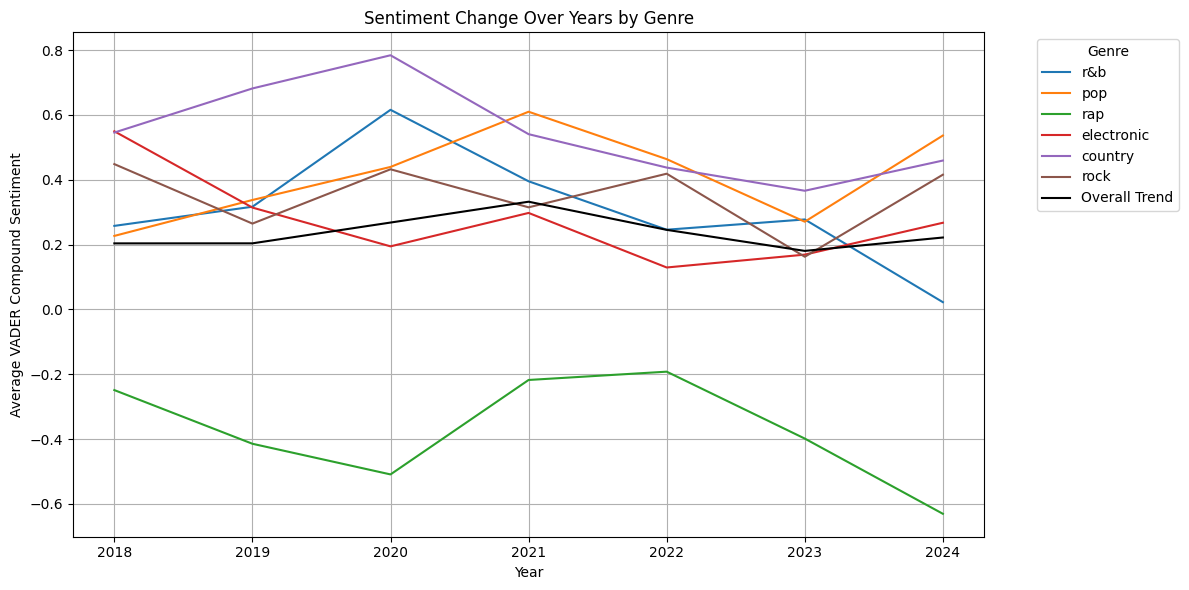

In [32]:
# Visualize sentiment development over time by genre (yearly average for a broad overview)

plt.figure(figsize=(12, 6))

sns.lineplot(data=df_sentiment, x='year', y='VADER_compound', hue='primary_tag', estimator='mean', errorbar=None) #average sentiment by year for better interpretability

# Add the overall yearly tend (not grouped by genre) for comparison
sns.lineplot(data=df_sentiment, x='year', y='VADER_compound', estimator='mean', errorbar=None, color='black', linewidth=1.5, label='Overall Trend')

plt.xlabel('Year')
plt.ylabel('Average VADER Compound Sentiment')
plt.title('Sentiment Change Over Years by Genre')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

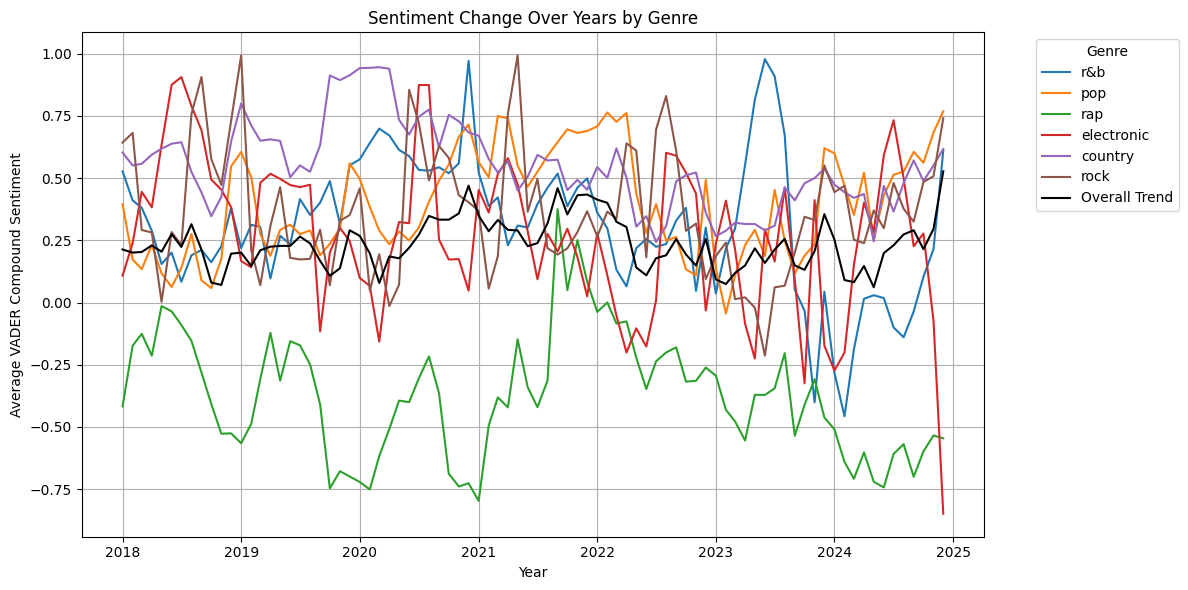

In [33]:
# Visualize sentiment development over time by genre (monthly averages for more fine gained analysis)

plt.figure(figsize=(12, 6))

sns.lineplot(data=df_sentiment, x='month_ts', y='VADER_compound', hue='primary_tag', estimator='mean', errorbar=None)

# Add the overall yearly tend (not grouped by genre) for comparison
sns.lineplot(data=df_sentiment, x='month', y='VADER_compound', estimator='mean', errorbar=None, color='black', linewidth=1.5, label='Overall Trend')

plt.xlabel('Year')
plt.ylabel('Average VADER Compound Sentiment')
plt.title('Sentiment Change Over Years by Genre')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

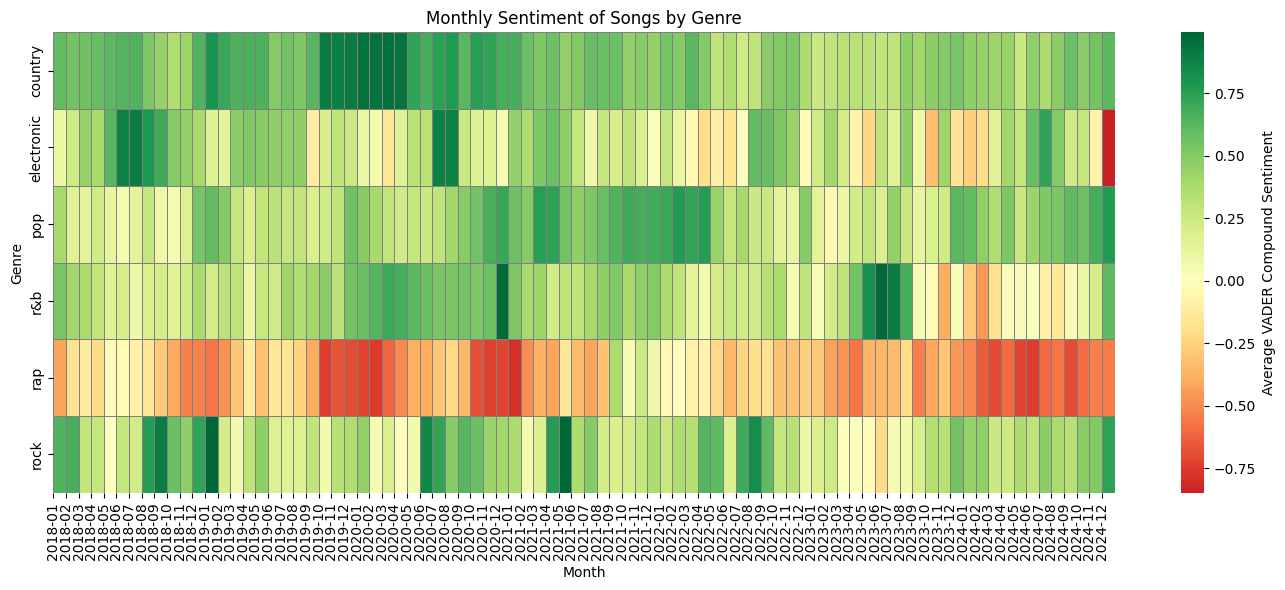

In [35]:
# Visualize sentiment evolution in a heatmap for easier trend detection

# Compute average sentiment per month per genre
sentiment_pivot = df_sentiment.pivot_table(
    index='primary_tag',
    columns='month',
    values='VADER_compound',
    aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    sentiment_pivot,
    cmap='RdYlGn',        # choose color map so red corresponds negative sentiment and green corresponds positive sentiment
    center=0,             # center at 0 for neutral sentiment
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Average VADER Compound Sentiment'})

ax = plt.gca()
ax.set_xticks(range(len(sentiment_pivot.columns)))
ax.set_xticklabels([d.strftime('%Y-%m') for d in sentiment_pivot.columns])

plt.title('Monthly Sentiment of Songs by Genre')
plt.xlabel('Month')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


In [36]:
# Compute the average sentiment per genre and year
sentiment_trend = df_sentiment.groupby(['year', 'primary_tag'], observed = True)['VADER_compound'].mean().reset_index()
sentiment_trend = sentiment_trend.pivot(index='year', columns='primary_tag', values='VADER_compound')
sentiment_trend

primary_tag   country  electronic       pop       r&b       rap      rock
year                                                                     
2018         0.545433    0.549388  0.226596  0.257567 -0.249006  0.448078
2019         0.681500    0.313980  0.337400  0.316598 -0.414582  0.264588
2020         0.783869    0.194369  0.439345  0.615567 -0.509156  0.432116
2021         0.540435    0.297487  0.609675  0.395105 -0.217792  0.314798
2022         0.437393    0.129211  0.463425  0.245712 -0.192191  0.418503
2023         0.365882    0.168844  0.270413  0.277386 -0.398569  0.162322
2024         0.459093    0.267176  0.536281  0.022192 -0.630620  0.415444

In [37]:
# Compute the overall sentiment per year
sentiment_trend_year = df_sentiment.groupby(['year'], observed = True)['VADER_compound'].mean().reset_index()
sentiment_trend_year

year  VADER_compound
0  2018        0.203555
1  2019        0.203673
2  2020        0.267798
3  2021        0.332092
4  2022        0.245300
5  2023        0.180370
6  2024        0.221675

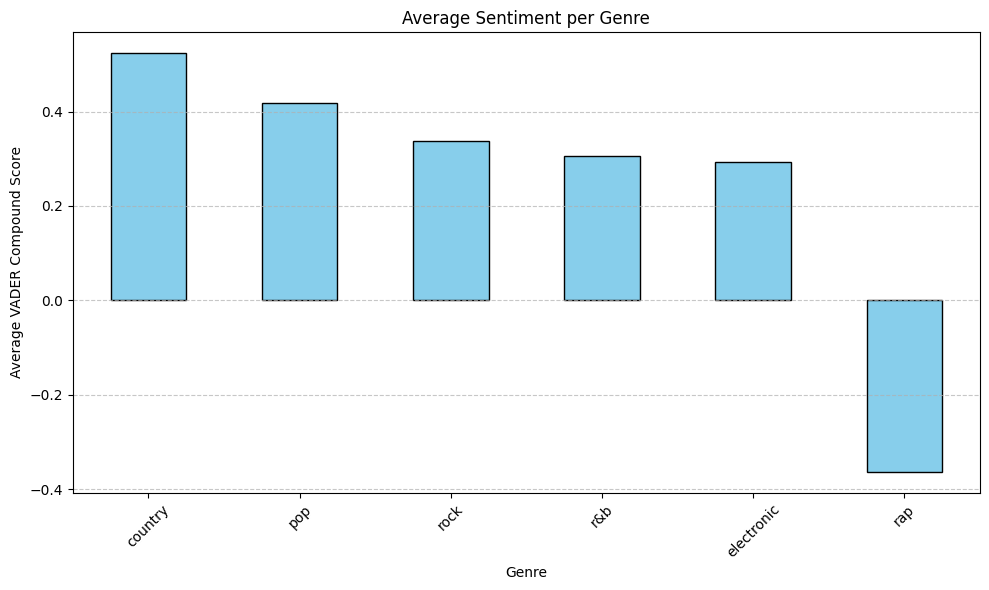

In [38]:
# Compute and visualize average sentiment for the different genres

avg_sentiment_per_genre = df_sentiment.groupby('primary_tag')['VADER_compound'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
avg_sentiment_per_genre.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Sentiment per Genre")
plt.xlabel("Genre")
plt.ylabel("Average VADER Compound Score")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

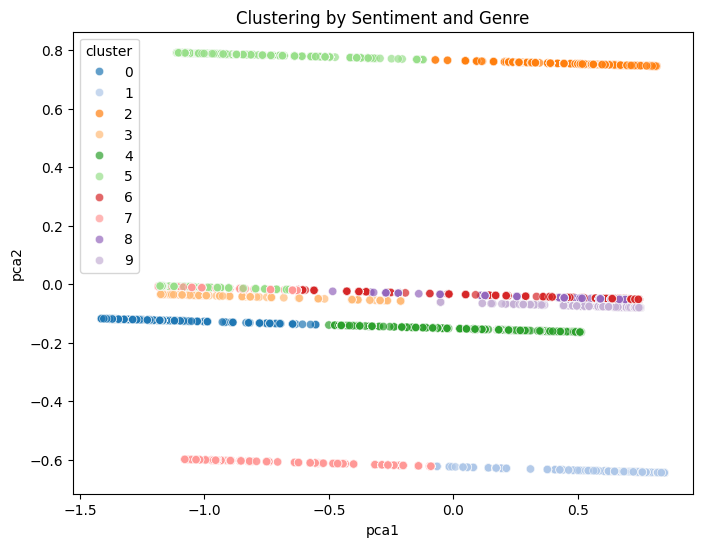

In [142]:
# Cluster the songs by genre and sentiment
# Idea: lyrics that are close both in genre and sentiment are closer together
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# One-hot encode genre
ohe = OneHotEncoder(sparse_output=False)
genre_encoded = ohe.fit_transform(df_sentiment[['primary_tag']])

# Combine VADER_compound with genre encoding
X = np.column_stack([df_sentiment['VADER_compound'].values, genre_encoded])

# KMeans clustering
kmeans = KMeans(n_clusters=10,n_init='auto', random_state=42)
df_sentiment['cluster'] = kmeans.fit_predict(X)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_sentiment['pca1'] = X_pca[:,0]
df_sentiment['pca2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_sentiment, x='pca1', y='pca2', hue='cluster', palette='tab20', alpha=0.7)
plt.title("Clustering by Sentiment and Genre")
plt.show()

In [143]:
# Getting deeper insights into the clustering
cluster_summary = (df_sentiment
                   .groupby('cluster')
                   .agg(avg_sentiment=('VADER_compound', 'mean'),
                        top_genre=('primary_tag', lambda x: x.value_counts().idxmax()),
                        count=('primary_tag', 'size'))
                   .sort_values('avg_sentiment'))

print(cluster_summary)

         avg_sentiment   top_genre  count
cluster                                  
0            -0.944976         rap   4014
3            -0.818776         r&b   1381
5            -0.798924         pop   2447
7            -0.755060     country   2098
8             0.734740  electronic   1533
6             0.761131        rock   1362
4             0.839204         rap   1944
2             0.918588         pop   4723
9             0.922835         r&b   2523
1             0.929568     country   4611


# 4. EDA - Topic Modeling

Prepare Data fpr Topic Modeling:

In [6]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Preprocess the lyrics
def preprocess_lyrics(lyrics):
    # Lowercase & remove special characters
    lyrics = re.sub(r"[^a-zA-Z\s]", "", lyrics.lower())

    # Tokenize
    tokens = nltk.word_tokenize(lyrics)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]

    return tokens

df["tokens"] = df["lyrics_clean"].apply(preprocess_lyrics)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


title                      artist  \
0              All I Want For Christmas Is You                Mariah Carey   
1  The Christmas Song (Merry Christmas To You)             Nat "King" Cole   
2                                  The Weekend                         SZA   
3                                     No Smoke  YoungBoy Never Broke Again   
4                                    New Rules                    Dua Lipa   

   genius_id primary_tag                                               tags  \
0     204233         r&b  [R&B, Pop, USA, In English, Soul Pop, Soul, Po...   
1    1717793         pop  [Pop, Big Band, Swing, Jazz, Acoustic, Holiday...   
2    3113598         r&b  [R&B, USA, In English, Psychedelic Soul, Neo S...   
3    3183597         rap                           [Rap, Dirty South, Trap]   
4    3013669  electronic  [Electronic, Pop, EDM, In English, UK Pop, Dan...   

  release_date                                              album  \
0   1994-10-29                                      Greatest Hits   
1         None  The Complete Capitol Recordings of The Nat Kin...   
2   2017-09-26                                      Ctrl (Deluxe)   
3   2017-08-03                                        AI YoungBoy   
4   2017-06-02                   Dua Lipa (Japan Special Edition)   

                                        lyrics_clean  chart_date  rank  peak  \
0  want lot christmas one thing need care present...  2018-01-06    13   1.0   
1  chestnuts roasting open fire jack frost nippin...  2018-01-06    42   9.0   
2  mood right mood say got girl want want got gir...  2018-01-06    33   NaN   
3  dj chose bro bro nigga homie count money fuck ...  2018-01-06    77  61.0   
4  one talkin sleep night makin crazy wrote read ...  2018-01-06    12   6.0   

   peak_date  year    month   month_ts  \
0 2019-12-21  2018  2018-01 2018-01-01   
1 2023-01-07  2018  2018-01 2018-01-01   
2        NaT  2018  2018-01 2018-01-01   
3 2018-02-03  2018  2018-01 2018-01-01   
4 2018-02-17  2018  2018-01 2018-01-01   

                                              tokens  
0  [want, lot, christmas, one, thing, need, care,...  
1  [chestnut, roasting, open, fire, jack, frost, ...  
2  [mood, right, mood, say, got, girl, want, want...  
3  [chose, bro, bro, nigga, homie, count, money, ...  
4  [one, talkin, sleep, night, makin, crazy, wrot...

In [7]:
# Define and remove custom stopwords to improve topic modeling results

topic_modeling_stopwords = {"oh", "yeah", "baby", "na", "la", "uh", "hey",
                           "could", "wan", "want", "youre", "cant", "thats",
                           "got", "one", "let", "get", "aint", "come", "there",
                           "take", "cause", "make", "tell", "said", "much",
                           "something", "thing", "ive", "say", "still", "see",
                           "back", "man", "well", "two", "gon", "keep", "need",
                           "feel", "keep", "wont", "time", "way", "never", "back",
                           "ill", "life", "as", "yea", "woha", "put", "ima", "tryna",
                           "imma", "yall", "chorus", "even", "whats", "might", "use",
                           "trying", "guess", "didnt", "saying", "who", "okay", "go",
                           "talk", "boom", "shall", "many", "may", "mmm", "must", "ooh",
                            "aye", "would", "youll", "ever", "everything", "going", "think",
                            "look", "find", "word", "another", "theyre", "also", "he", "dont",
                            "give", "around","made", "nothing", "woah", "lil", "ayy", "damn",
                            "huh", "nothin", "somethin", "huh", "right", "done", "next",
                            "good", "right", "coming", "always", "thought", "bout", "doin",
                            "gettin", "new", "try", "mean", "thinkin", "tough", "whatever",
                            "day", "along", "maybe", "without", "better"
                           }

df['tokens'] = df['tokens'].apply(lambda token_list: [t for t in token_list if t.lower() not in topic_modeling_stopwords])

In [8]:
# Preparing data for LDA topic modeling

# Surpress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Get dictionary that maps words (tokens) to IDs
dictionary = corpora.Dictionary(df["tokens"])

# Filter extremes(words that appear in less than 30 or more than 50% of the lyrics)to enable meaningful results
dictionary.filter_extremes(no_below=15, no_above=0.5)

# Transform every lyric into a bag-of-words vector that will be passed to the LDA model
corpus = [dictionary.doc2bow(text) for text in df["tokens"]]

LDA Model Training:

In [19]:
# Surpress warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from gensim.models.ldamodel import LdaModel

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=7,        # number of topics the model tries to fit the lyrics into - choosen based on experimentation
    passes=10,           # number of full passes the algortihm makes over the data corpus
    random_state=42,
    chunksize=100,
    per_word_topics=True
)

LDA Results and interpretation:

In [20]:
# Display top words in each topic together with their assigned importance

# Surpress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

for idx, topic in lda_model.print_topics(num_words=20):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.056*"bell" + 0.048*"jingle" + 0.043*"missin" + 0.043*"fun" + 0.041*"skin" + 0.030*"airport" + 0.025*"habit" + 0.021*"redrum" + 0.020*"apple" + 0.020*"horse" + 0.015*"sleigh" + 0.014*"kehlani" + 0.013*"party" + 0.010*"hangin" + 0.010*"obvious" + 0.010*"alcohol" + 0.009*"john" + 0.009*"los" + 0.009*"white" + 0.008*"fever"
Topic 1: 0.030*"love" + 0.020*"lie" + 0.014*"left" + 0.014*"alone" + 0.013*"bad" + 0.013*"miss" + 0.012*"mine" + 0.012*"show" + 0.011*"guy" + 0.011*"pink" + 0.010*"sleep" + 0.010*"call" + 0.009*"luck" + 0.008*"die" + 0.008*"pony" + 0.008*"anyway" + 0.007*"night" + 0.007*"lovin" + 0.007*"sorry" + 0.007*"club"
Topic 2: 0.030*"smoke" + 0.024*"roll" + 0.023*"glo" + 0.023*"ghost" + 0.021*"toe" + 0.019*"disease" + 0.017*"west" + 0.015*"holy" + 0.015*"red" + 0.015*"riding" + 0.013*"young" + 0.013*"wicked" + 0.012*"chris" + 0.011*"supernova" + 0.010*"walk" + 0.010*"parent" + 0.010*"saint" + 0.010*"guitar" + 0.010*"famous" + 0.008*"beyond"
Topic 3: 0.033*"bitch" + 0.0

In [14]:
# !pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.9 MB/s eta 0:00:00


In [25]:
# Interactive visualization of LDA results
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Surpress warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

In [26]:
# Assign each lyric its dominati topic

def get_dominant_topic(bow):
    topics = lda_model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0] if topics else None

df["topic"] = [get_dominant_topic(bow) for bow in corpus]

# Define a mapping from topic ID to a human-readable label
topic_labels = {
    0: "Holiday/Party Theme",
    1: "Romantic Struggles",
    2: "Dark/Mystical Imagery",
    3: "Rap/Expressive Language",
    4: "Heartbreak & Drinking",
    5: "Country Lifestyle",
    6: "Love & Devotion"}

# Add a new column with the descriptive topic name
df["topic_name"] = df["topic"].map(topic_labels)

df.head(10)

title  \
0              All I Want For Christmas Is You   
1  The Christmas Song (Merry Christmas To You)   
2                                  The Weekend   
3                                     No Smoke   
4                                    New Rules   
5     It's The Most Wonderful Time Of The Year   
6                          Written In The Sand   
7                                     MIC Drop   
8                              Lights Down Low   
9                             Codeine Dreaming   

                            artist  genius_id primary_tag  \
0                     Mariah Carey     204233         r&b   
1                  Nat "King" Cole    1717793         pop   
2                              SZA    3113598         r&b   
3       YoungBoy Never Broke Again    3183597         rap   
4                         Dua Lipa    3013669  electronic   
5                   and y Williams    2255377         pop   
6                     Old Dominion    3148145         pop   
7          BTS Featuring Desiigner    3306598  electronic   
8              MAX Featuring Gnash    9341114         pop   
9  Kodak Black Featuring Lil Wayne    3713470         rap   

                                                tags release_date  \
0  [R&B, Pop, USA, In English, Soul Pop, Soul, Po...   1994-10-29   
1  [Pop, Big Band, Swing, Jazz, Acoustic, Holiday...         None   
2  [R&B, USA, In English, Psychedelic Soul, Neo S...   2017-09-26   
3                           [Rap, Dirty South, Trap]   2017-08-03   
4  [Electronic, Pop, EDM, In English, UK Pop, Dan...   2017-06-02   
5                          [Pop, Christmas, Holiday]   1963-10-14   
6  [Pop, Country, Chillout, Tropical House, Adult...   2017-07-07   
7  [Electronic, Rap, East Coast Rap, New York Rap...   2017-11-24   
8               [Pop, USA, In English, Live, Ballad]   2017-05-31   
9                                      [Rap, Canada]   2018-05-13   

                                               album  \
0                                      Greatest Hits   
1  The Complete Capitol Recordings of The Nat Kin...   
2                                      Ctrl (Deluxe)   
3                                        AI YoungBoy   
4                   Dua Lipa (Japan Special Edition)   
5                              40 Christmas Classics   
6                                  Odies But Goodies   
7              NOW That’s What I Call Music! 65 [US]   
8                                    Spotify Singles   
9          OVO Sound Radio Tracklists - Season 1 & 2   

                                        lyrics_clean  chart_date  rank  peak  \
0  want lot christmas one thing need care present...  2018-01-06    13   1.0   
1  chestnuts roasting open fire jack frost nippin...  2018-01-06    42   9.0   
2  mood right mood say got girl want want got gir...  2018-01-06    33   NaN   
3  dj chose bro bro nigga homie count money fuck ...  2018-01-06    77  61.0   
4  one talkin sleep night makin crazy wrote read ...  2018-01-06    12   6.0   
5  wonderful time year kids jingle belling everyo...  2018-01-06    38   5.0   
6  turn turn turn back weekend say words want fli...  2018-01-06    86  51.0   
7  lyrics remixed version mic drop bts remix rele...  2018-01-06    82   NaN   
8  heaven knows really need know know gonna go he...  2018-01-06    54  20.0   
9  oliver set aftertheparty bargain drake trust i...  2018-01-06    70   NaN   

   peak_date  year    month   month_ts  \
0 2019-12-21  2018  2018-01 2018-01-01   
1 2023-01-07  2018  2018-01 2018-01-01   
2        NaT  2018  2018-01 2018-01-01   
3 2018-02-03  2018  2018-01 2018-01-01   
4 2018-02-17  2018  2018-01 2018-01-01   
5 2021-01-02  2018  2018-01 2018-01-01   
6 2018-02-17  2018  2018-01 2018-01-01   
7        NaT  2018  2018-01 2018-01-01   
8 2018-03-03  2018  2018-01 2018-01-01   
9        NaT  2018  2018-01 2018-01-01   

                                              tokens  topic  \
0  [lot, christmas, care, present,

In [37]:
# Save the dataframe
df.to_csv("/content/drive/MyDrive/EDA_df.csv", index=False)

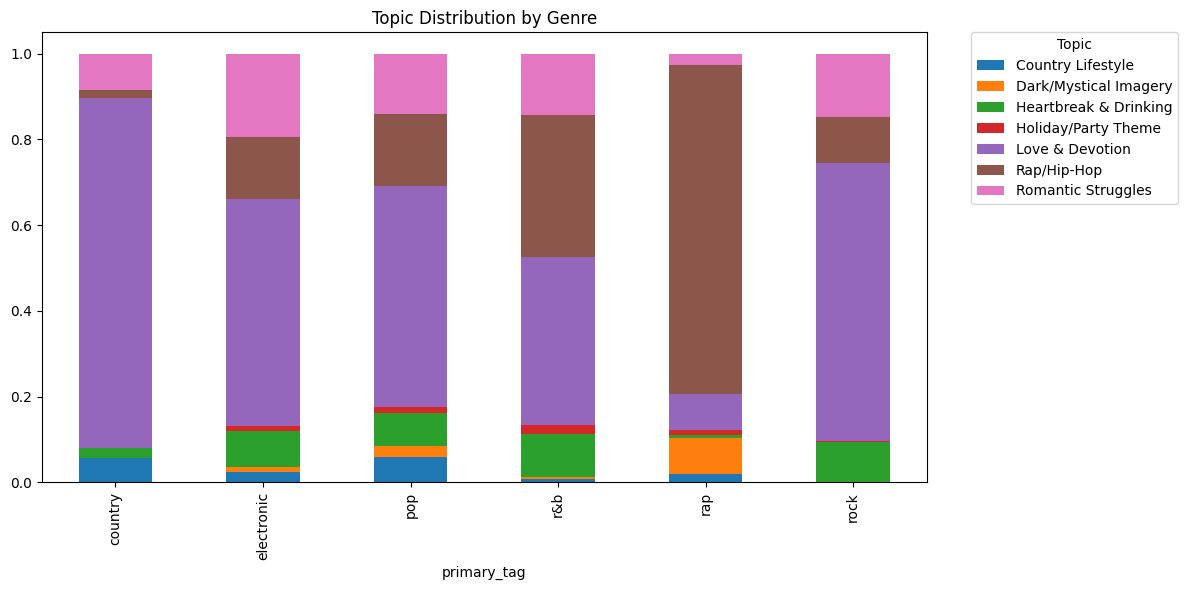

In [27]:
# Visualize the dominating topic per genre

# Group by genre
genre_topic_dist = df.groupby("primary_tag", observed = True)["topic_name"].value_counts(normalize=True).unstack().fillna(0)

ax = genre_topic_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title="Topic Distribution by Genre")


ax.legend(
    title="Topic",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    labels=genre_topic_dist.columns)

plt.tight_layout()
plt.show()

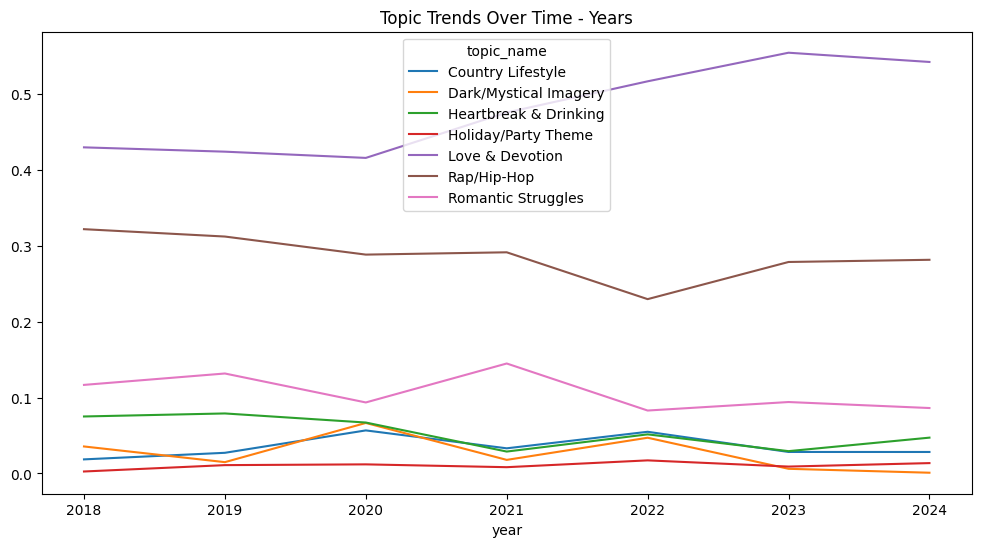

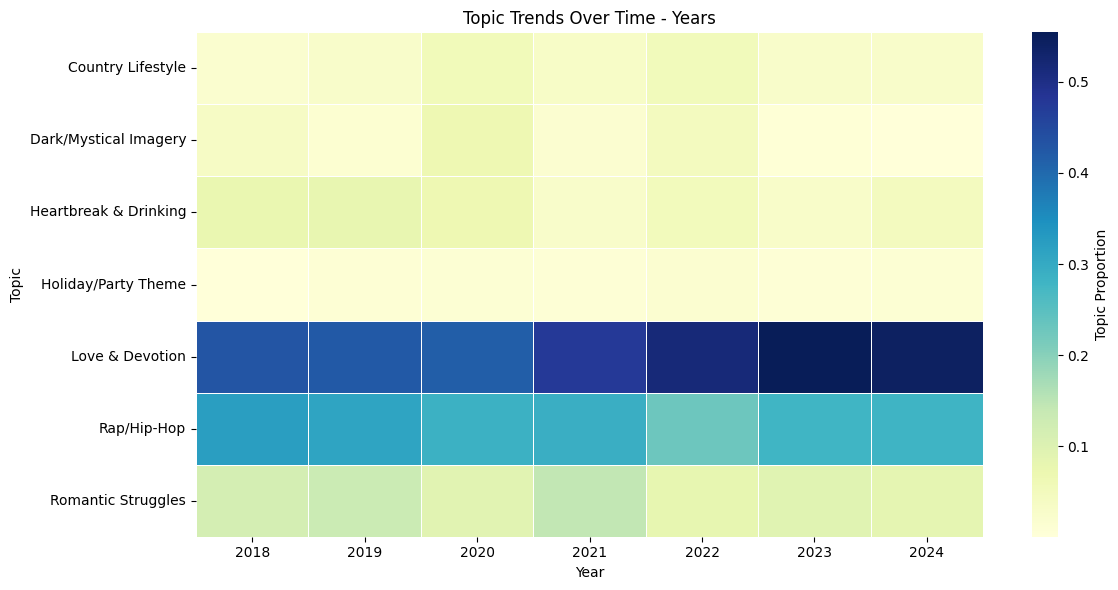

In [28]:
# Compute the evolution of the dominace of different topics during the observation period

# Group by year for a broad overview of trend evolution
year_topic_dist = df.groupby("year", observed = True)["topic_name"].value_counts(normalize=True).unstack().fillna(0)
year_topic_dist.plot(kind="line", figsize=(12, 6), title="Topic Trends Over Time - Years")
plt.ylabel("Topic Proportion")
plt.xlabel("Year")

# Create a heatmap for better interpretability
plt.figure(figsize=(12, 6))
sns.heatmap(year_topic_dist.T, cmap="YlGnBu", linewidths=0.5, annot=False, cbar_kws={'label': 'Topic Proportion'})
plt.title("Topic Trends Over Time - Years")
plt.xlabel("Year")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

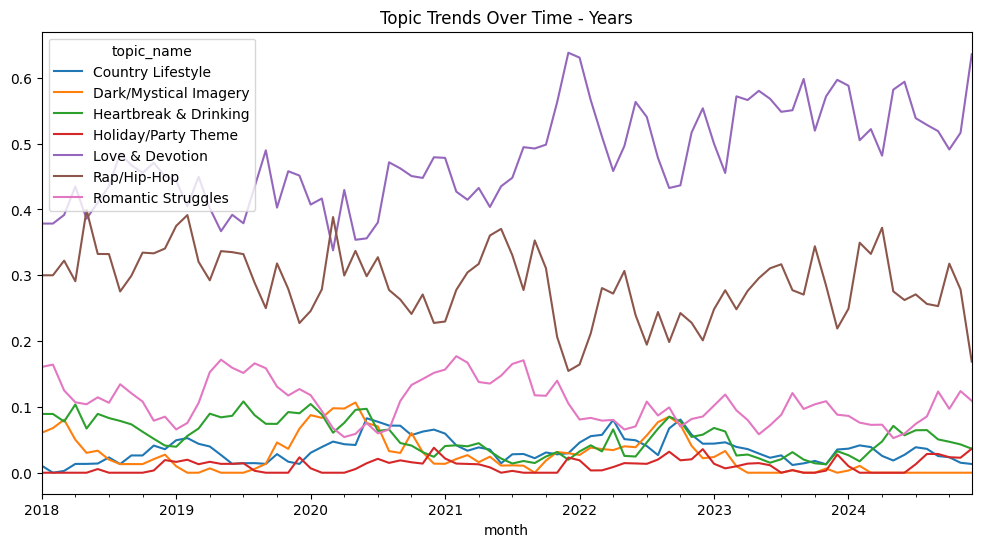

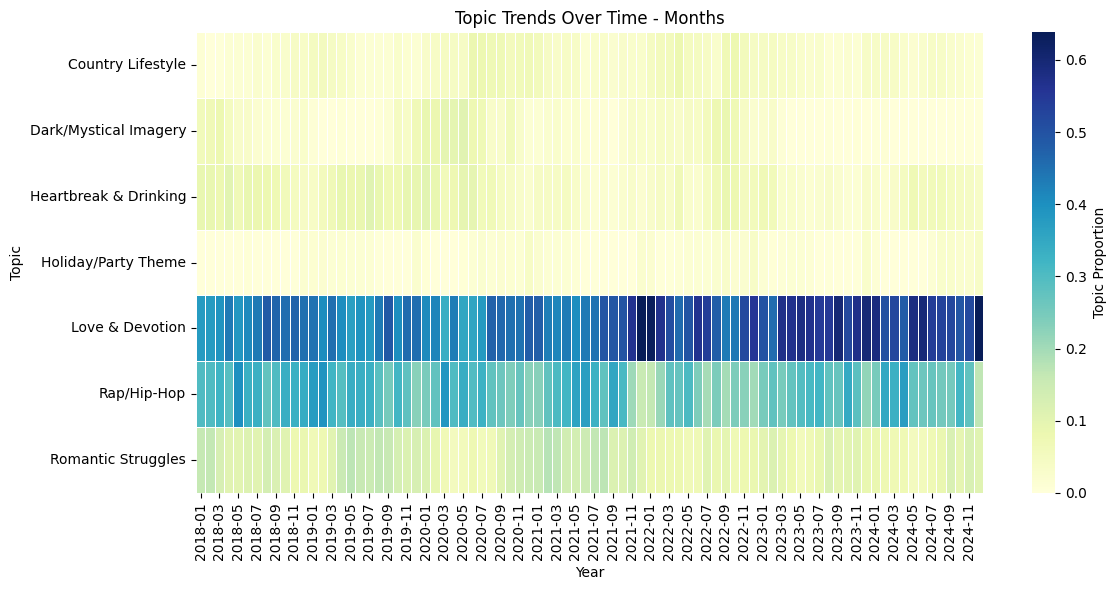

In [29]:
# Compute the monthly evolution of the dominace of different topics during the observation period

# Group by month for more fine grained analysis
month_topic_dist = df.groupby("month", observed = True)["topic_name"].value_counts(normalize=True).unstack().fillna(0)
month_topic_dist.plot(kind="line", figsize=(12, 6), title="Topic Trends Over Time - Month")
plt.ylabel("Topic Proportion")
plt.xlabel("Year")

# Create a heatmap for better interpretability
plt.figure(figsize=(12, 6))
sns.heatmap(month_topic_dist.T, cmap="YlGnBu", linewidths=0.5, annot=False, cbar_kws={'label': 'Topic Proportion'})
plt.title("Topic Trends Over Time - Months")
plt.xlabel("Year")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

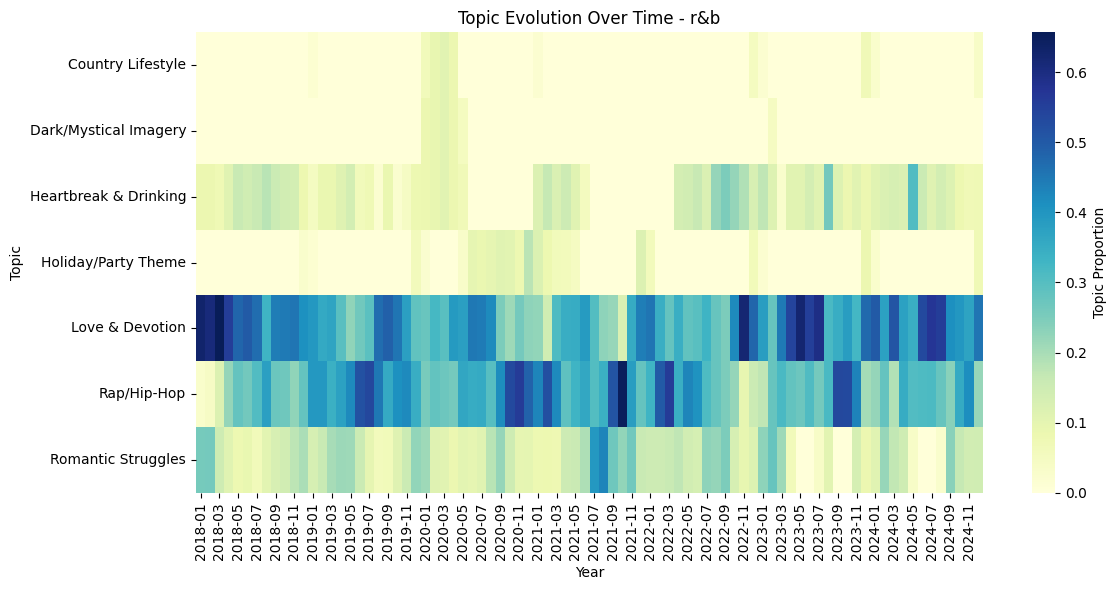

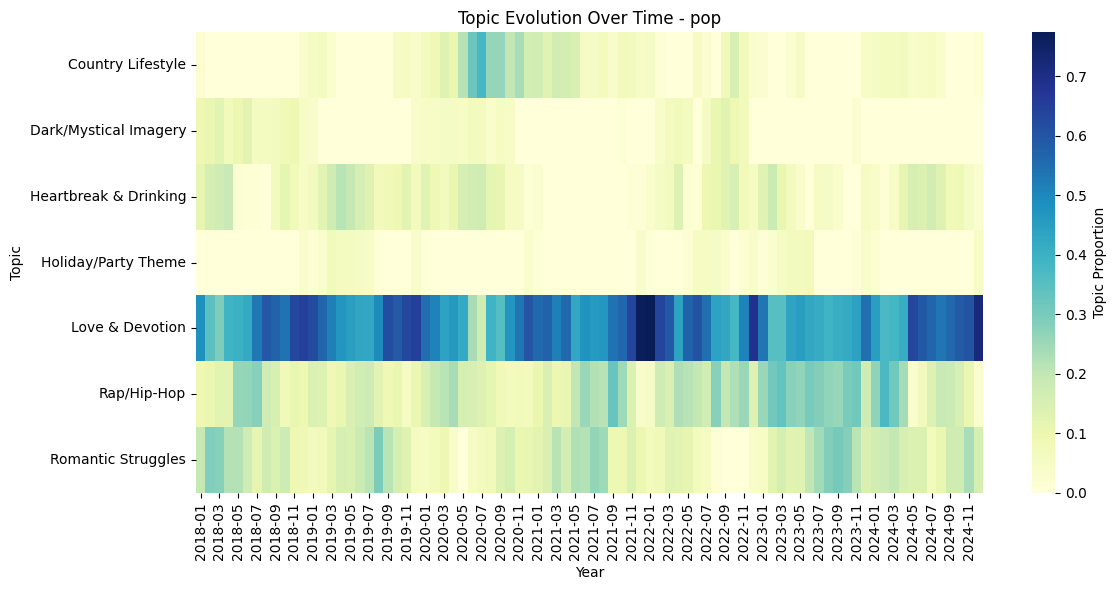

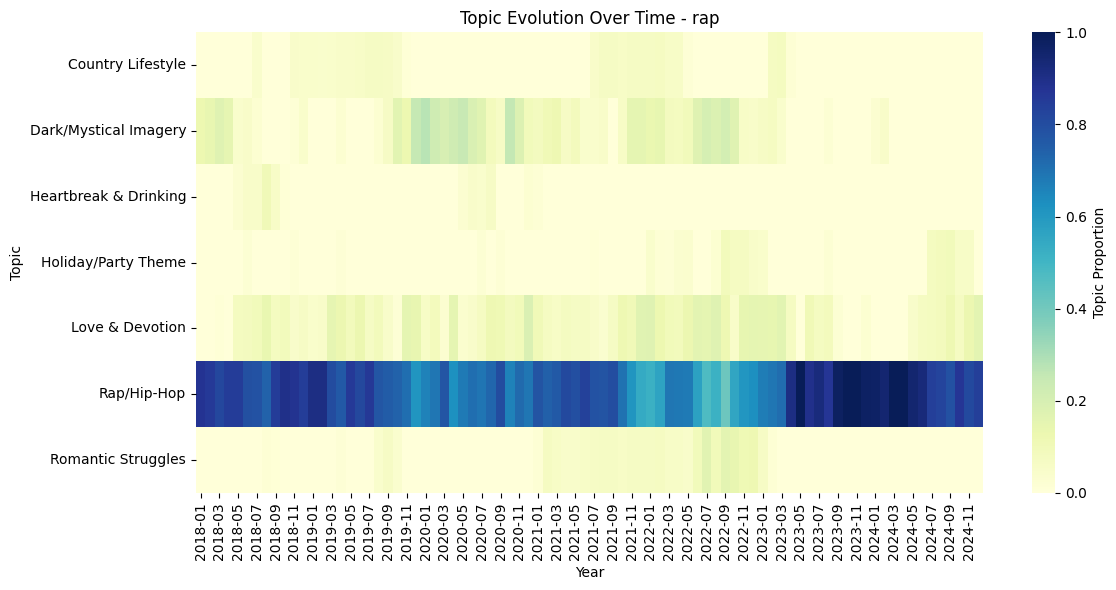

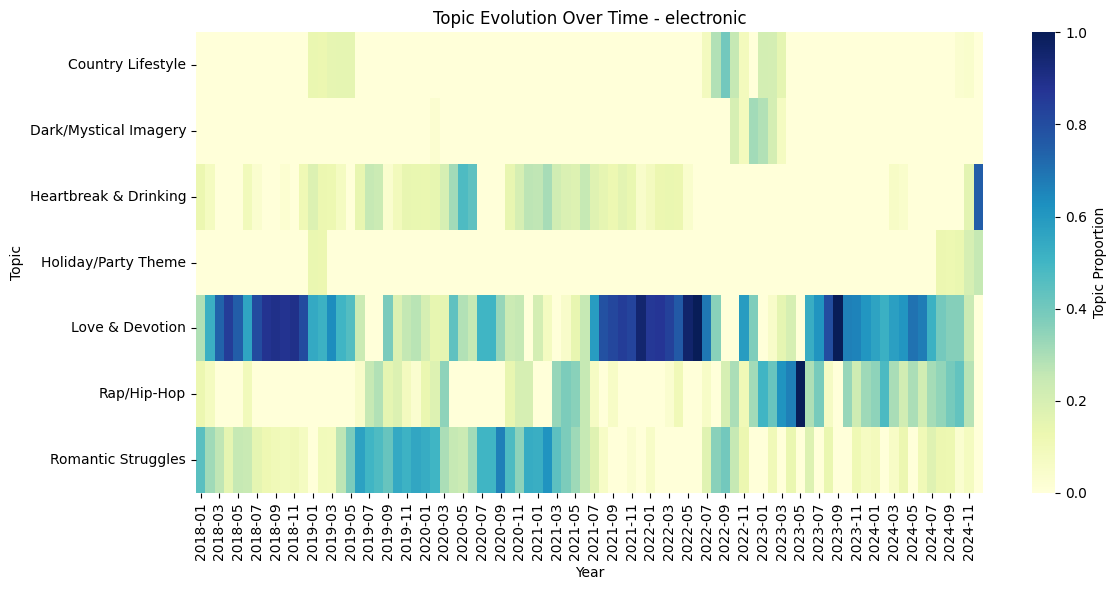

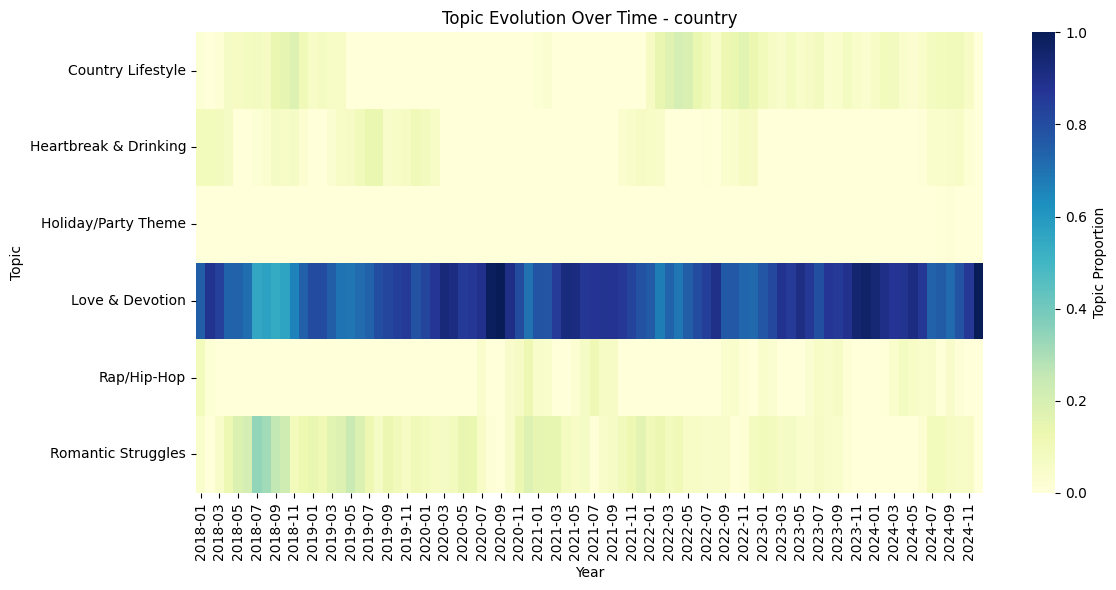

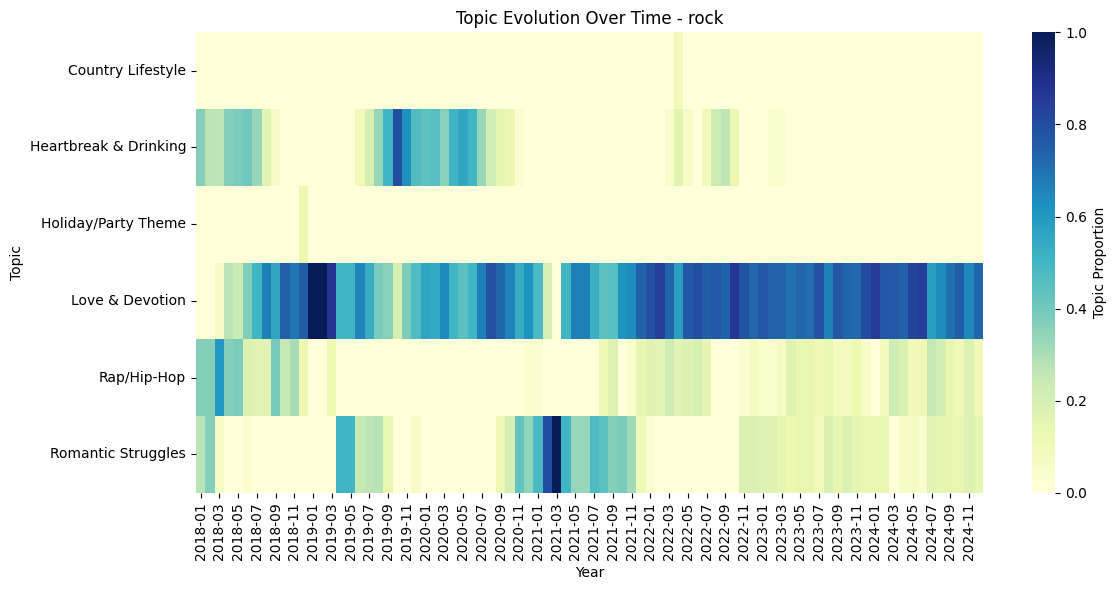

In [31]:
# Compute the monthly evolution of the dominace of different topics during the observation period by genre (Heatmaps)

# Group by genre and month and topic (topic frequencies by genre and month)
genre_year_topic = (
    df.groupby(["primary_tag", "month", "topic_name"])
    .size()
    .reset_index(name="count"))

# Convert to proportion within each genre-month
genre_year_topic["proportion"] = genre_year_topic.groupby(
    ["primary_tag", "month"]
)["count"].transform(lambda x: x / x.sum())

# Get unique genres
genres = df["primary_tag"].unique()

# Loop through each genre and plot a heatmap for the evolution of topic dominance within each genre over time
for genre in genres:
    genre_data = genre_year_topic[genre_year_topic["primary_tag"] == genre]

    pivot_data = genre_data.pivot(index="topic_name", columns="month", values="proportion").fillna(0)

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        pivot_data,
        cmap="YlGnBu",
        annot=False,
        cbar_kws={'label': 'Topic Proportion'})

    plt.title(f"Topic Evolution Over Time - {genre}")
    plt.xlabel("Time")
    plt.ylabel("Topic")
    plt.tight_layout()
    plt.show()

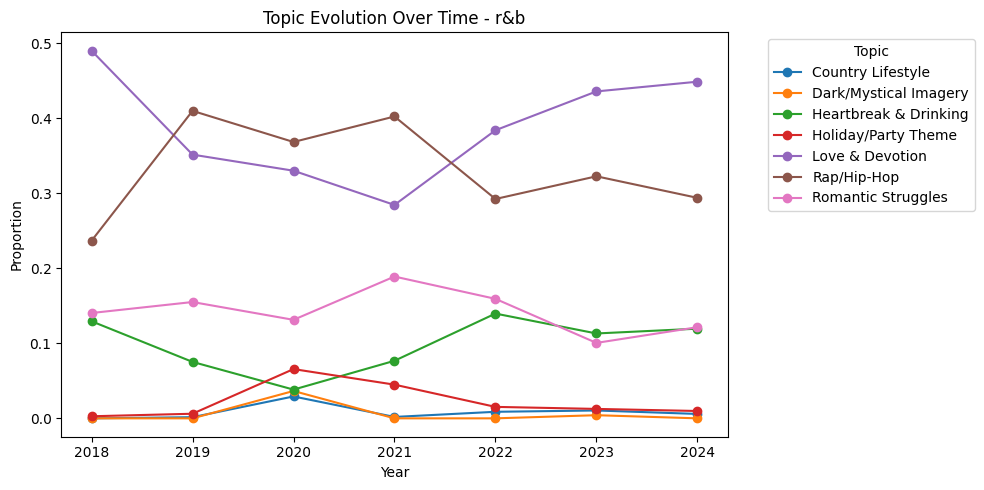

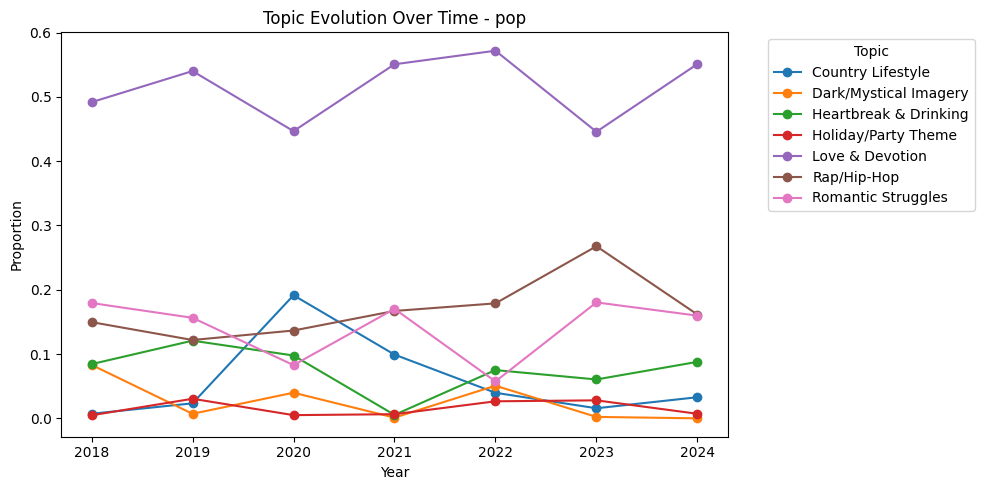

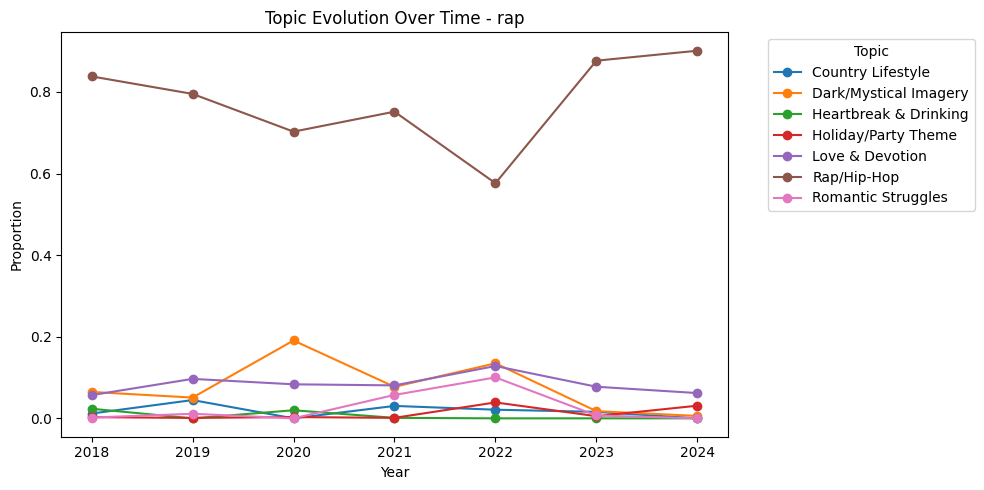

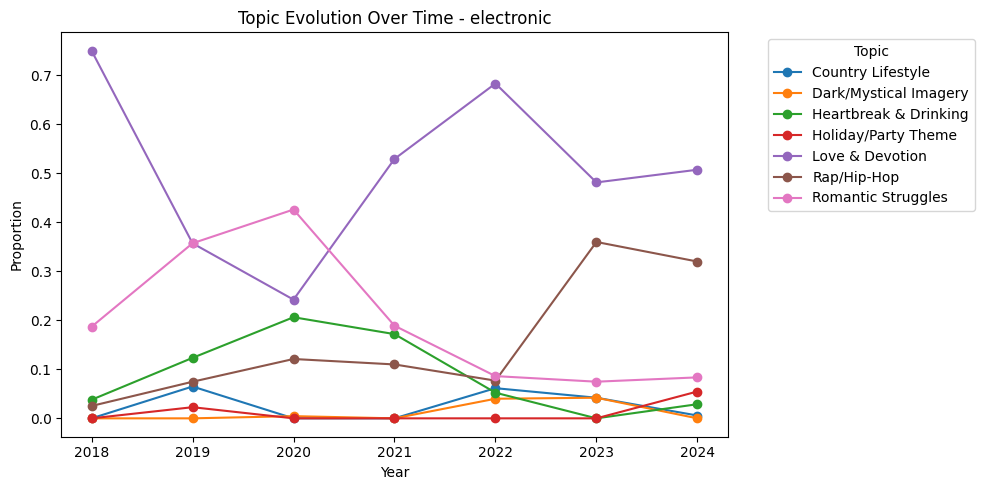

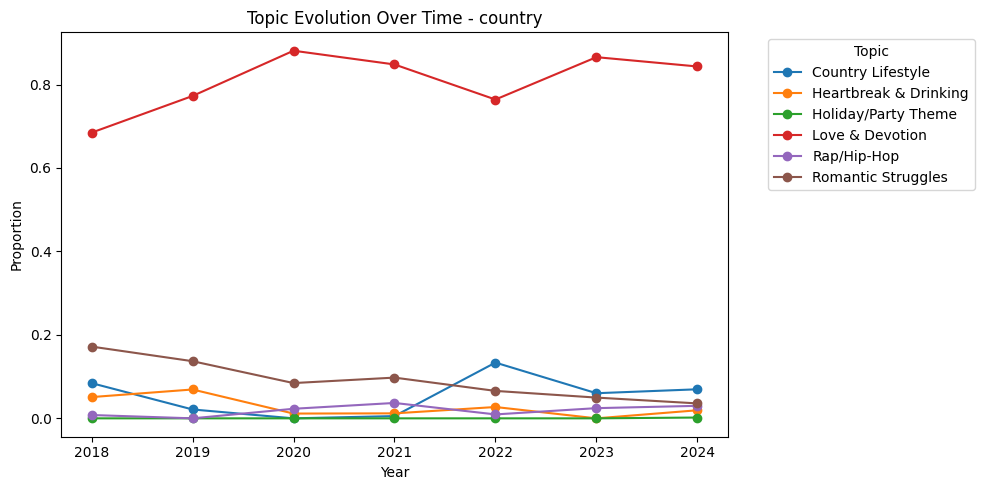

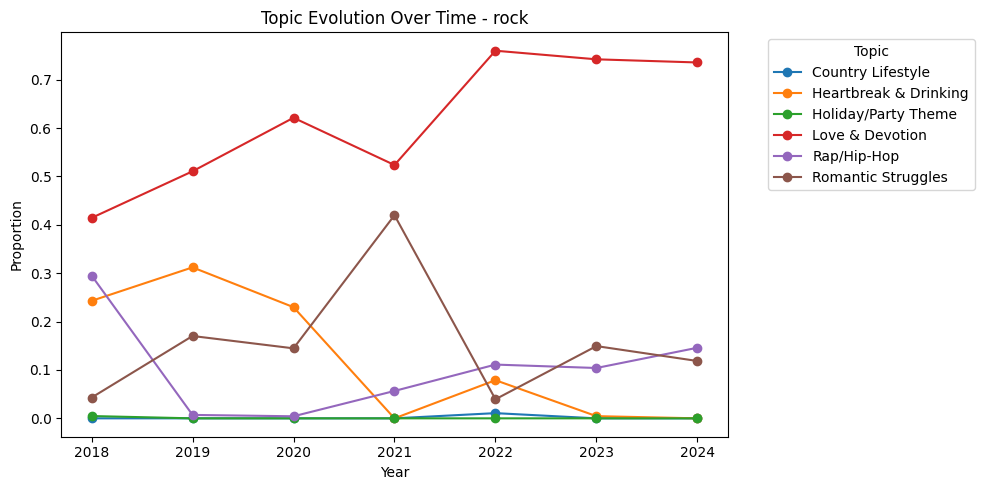

In [32]:
# Compute the monthly evolution of the dominace of different topics during the observation period by genre (Lineplots)

# Group by genre, year and topic
genre_year_topic = (
    df.groupby(["primary_tag", "year", "topic_name"])
    .size()
    .reset_index(name="count"))

# Convert to proportion within each genre-year
genre_year_topic["proportion"] = genre_year_topic.groupby(["primary_tag", "year"])["count"].transform(lambda x: x / x.sum())

# Get unique genres
genres = df["primary_tag"].unique()

for genre in genres:
    genre_data = genre_year_topic[genre_year_topic["primary_tag"] == genre]
    pivot_data = genre_data.pivot(index="year", columns="topic_name", values="proportion").fillna(0)

    pivot_data.plot(
        kind="line",
        marker="o",
        figsize=(10, 5),
        title=f"Topic Evolution Over Time - {genre}"
    )
    plt.ylabel("Topic Proportion")
    plt.xlabel("Year")
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# 5. EDA - Artist Trajectory Analysis

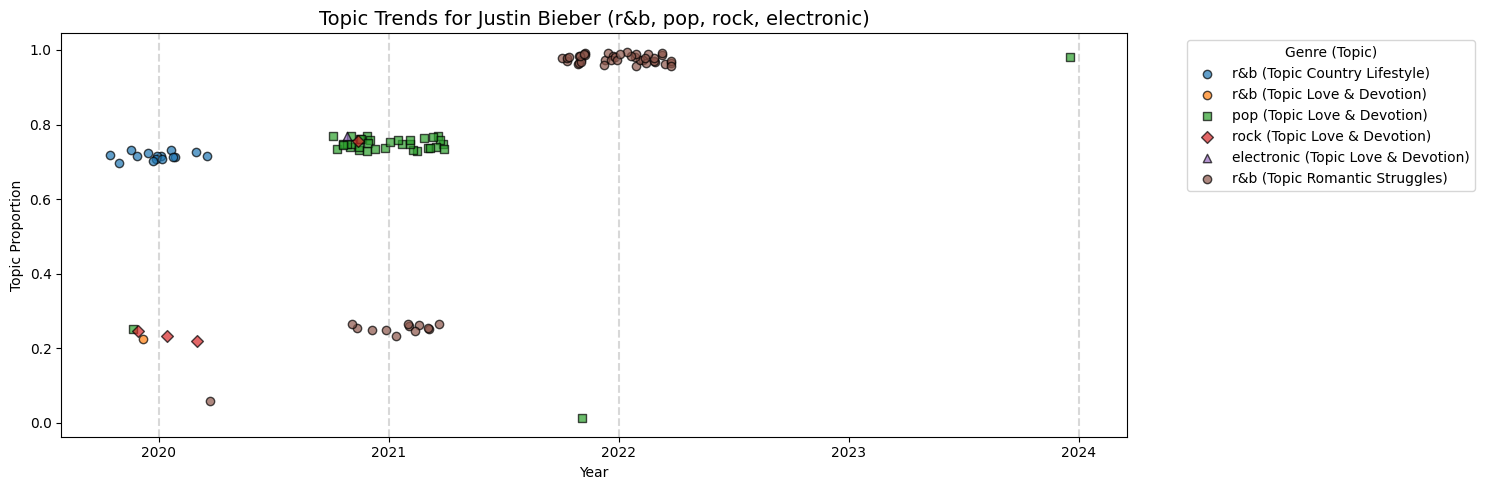

In [35]:
# Visualize topic and genre evolution of an artist
artist = "Justin Bieber"
artist_df = df[df["artist"].str.lower() == artist.lower()] #gather all songs from the respective artist

# Get genre info of the artists songs
artist_genres = artist_df["primary_tag"].unique()

# Map genres to markers
markers = ['o', 's', 'D', '^', 'v', '*']
genre_marker_map = {genre: markers[i % len(markers)] for i, genre in enumerate(artist_genres)}

# Visualization
fig, ax = plt.subplots(figsize=(15, 5))

# Add release year markers (vertical dashed lines)
for year in sorted(artist_df["year"].unique()):
    ax.axvline(x=year, color="gray", linestyle="--", alpha=0.3)

x_jitter_strength = 0.25
y_jitter_strength = 0.02

for topic in artist_topic_by_year.columns:
    topic_data = artist_df[artist_df["topic_name"] == topic]

    for genre in topic_data["primary_tag"].unique():
        genre_data = topic_data[topic_data["primary_tag"] == genre]
        x_vals = genre_data["year"] + np.random.uniform(-x_jitter_strength, x_jitter_strength, size=len(genre_data))
        y_vals = [artist_topic_by_year.loc[y, topic] for y in genre_data["year"]]
        y_vals_jittered = y_vals + np.random.uniform(-y_jitter_strength, y_jitter_strength, size=len(genre_data))

        ax.scatter(
            x_vals,
            y_vals_jittered,
            alpha=0.7,
            edgecolors="black",
            marker=genre_marker_map[genre],
            label=f"{genre} (Topic {topic})"
        )

ax.set_title(f"Topic Trends for {artist} ({', '.join(artist_genres)})", fontsize=14)
ax.set_xlabel("Year")
ax.set_ylabel("Topic Proportion")

# Remove duplicate legend entries by creating a dictionary keyed by label
handles, labels = ax.get_legend_handles_labels()
unique = dict()
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h
ax.legend(unique.values(), unique.keys(), title="Genre (Topic)", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

# 6. EDA - Further Analysis

**Analysis regarding the peak of a song:**

In [39]:
# Create a dataframe comprising all songs that reached the top of the charts
rank1_songs = df[df['rank'] == 1].copy()

# Reduce to relevant information
rank1_week_genre = rank1_songs[['chart_date', 'primary_tag']]

# Pivot to get weeks as index and genres as columns
rank1_genre = rank1_week_genre.groupby(['chart_date', 'primary_tag']).size().unstack(fill_value=0)
rank1_genre.head()

primary_tag  country  electronic  pop  r&b  rap  rock
chart_date                                           
2018-01-06         0           0    1    0    0     0
2018-01-13         0           0    1    0    0     0
2018-01-20         0           0    1    0    0     0
2018-02-03         0           0    1    0    0     0
2018-02-10         0           0    1    0    0     0

primary_tag
pop           37.847222
rap           17.013889
country       14.236111
r&b           13.541667
rock          11.458333
electronic     5.902778
dtype: float64


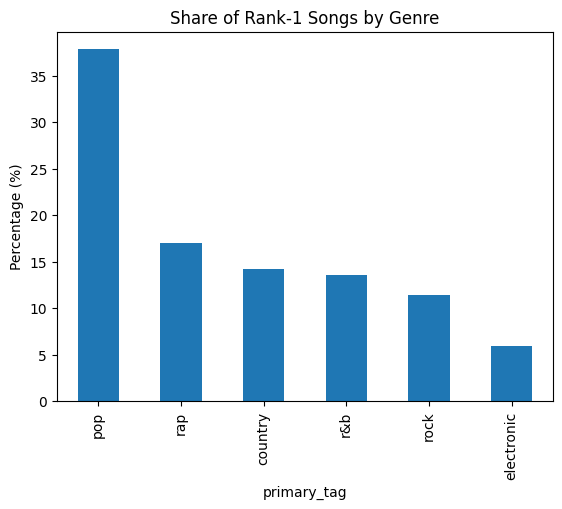

In [40]:
# Calculate the share of top songs per genre
genre_percentages = rank1_genre.sum() / rank1_genre.sum().sum() * 100
genre_percentages = genre_percentages.sort_values(ascending=False)
print(genre_percentages)

# Visualization
genre_percentages.plot(kind='bar', ylabel='Percentage (%)', title='Share of Rank-1 Songs by Genre')
plt.show()

In [48]:
# Computing the weighted popularity of a genre

# Assign a popularity weight to each song (100 for rank 1, 1 for rank 100) and group by genre
df['rank_weight'] = 101 - df['rank']
genre_popularity = df.groupby('primary_tag')['rank_weight'].sum()

# Compute percentages
genre_popularity_pct = genre_popularity / genre_popularity.sum() * 100
genre_popularity_pct = genre_popularity_pct.sort_values(ascending=False)
print(genre_popularity_pct.sort_values(ascending=False))

primary_tag
pop           28.053885
rap           21.401554
country       18.445711
r&b           15.873964
electronic     8.884782
rock           7.340104
Name: rank_weight, dtype: float64


Interpretation: Each song was assigned a weight based on its rank, with rank 1 receiving 100 points, rank 2 receiving 99, ... and rank 100 receiving 1 point. These weights were then summed across all weeks for each genre, so genres with frequent high-ranking songs accumulated more points than those  appearing mostly in lower positions. Finally the percentages represent each genre’s share of the total weighted popularity.

<Figure size 1200x600 with 0 Axes>

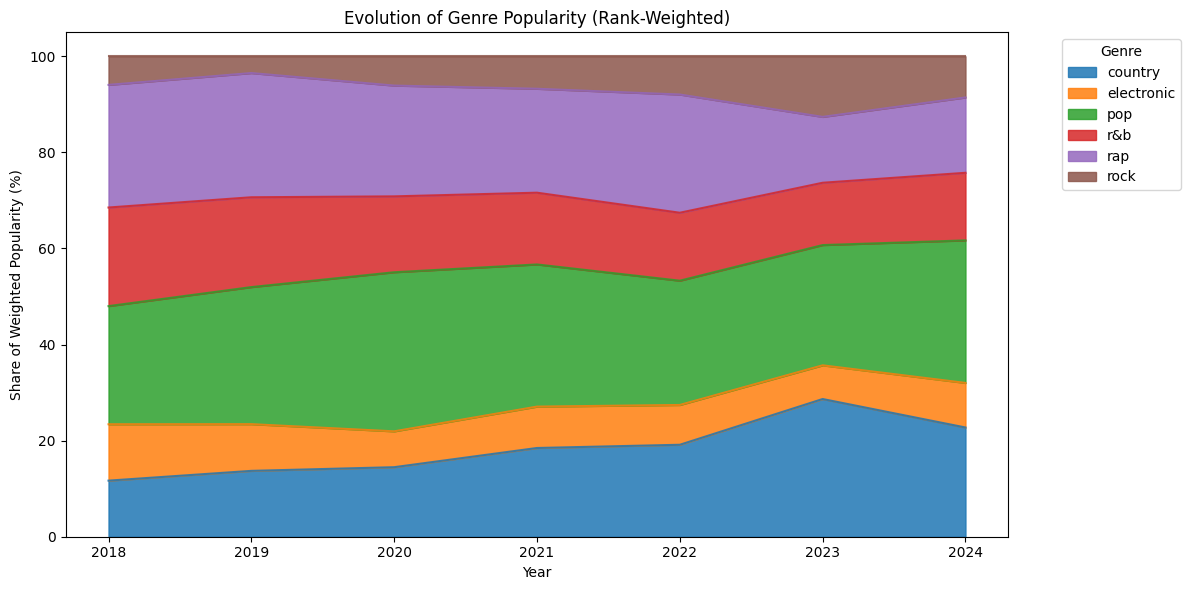

In [49]:
# Compute evolution of weighted popularity per genre over time (yearly)

# Group by genre and year
genre_popularity_year = (
    df.groupby(['year', 'primary_tag'])['rank_weight']
      .sum()
      .unstack(fill_value=0))

# Compute percentages
genre_popularity_pct_year = genre_popularity_year.div(genre_popularity_year.sum(axis=1), axis=0) * 100

# Visualization
plt.figure(figsize=(12,6))
genre_popularity_pct_year.plot(kind='area', stacked=True, alpha=0.85, figsize=(12,6))

plt.title("Evolution of Genre Popularity (Rank-Weighted) - Yearly")
plt.xlabel("Year")
plt.ylabel("Share of Weighted Popularity (%)")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

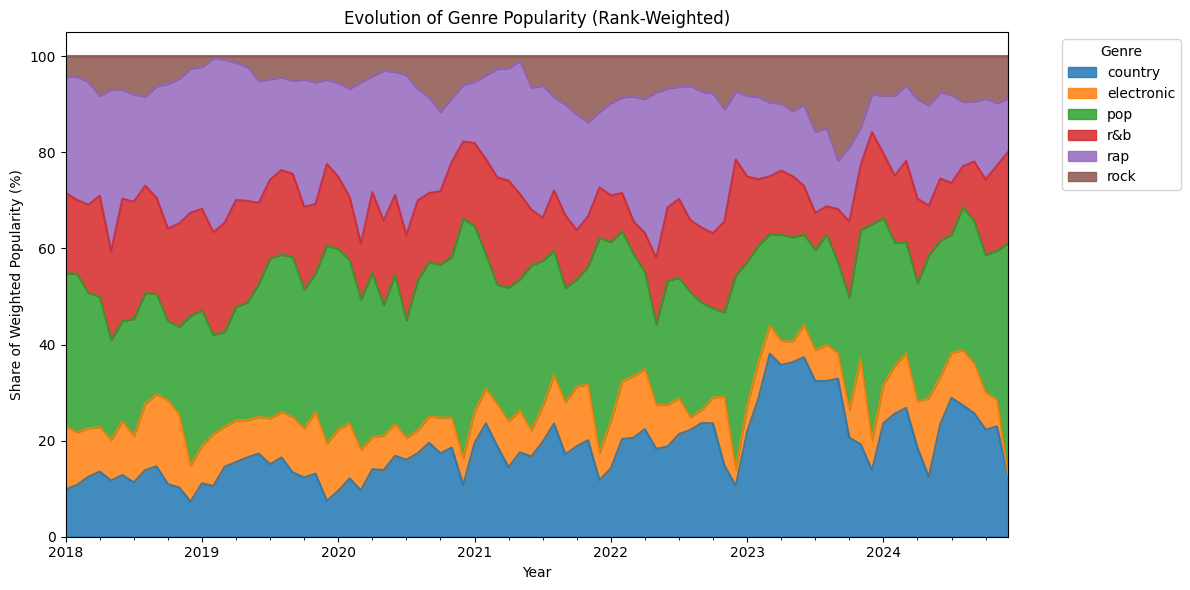

In [50]:
# Compute evolution of weighted popularity per genre over time (monthly)

# Group by month and genre
genre_popularity_month = (
    df.groupby(['month', 'primary_tag'])['rank_weight']
      .sum()
      .unstack(fill_value=0))

# Compute percentages
genre_popularity_pct_month = genre_popularity_month.div(genre_popularity_month.sum(axis=1), axis=0) * 100

# Visualization
plt.figure(figsize=(12,6))
genre_popularity_pct_month.plot(kind='area', stacked=True, alpha=0.85, figsize=(12,6))

plt.title("Evolution of Genre Popularity (Rank-Weighted)- Monthly")
plt.xlabel("Year")
plt.ylabel("Share of Weighted Popularity (%)")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

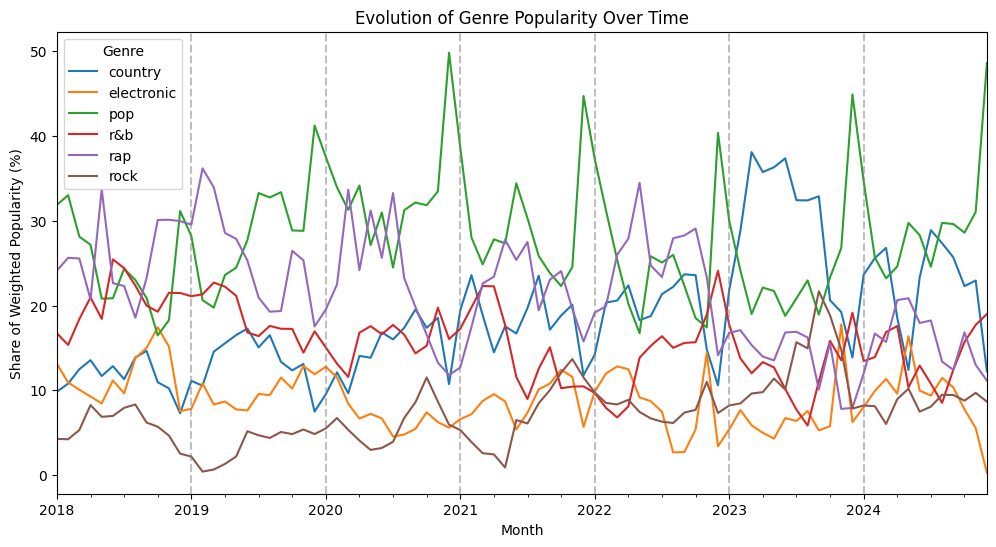

In [51]:
# Visualize as lineplot

plt.figure(figsize=(12,6))
ax = genre_popularity_pct.plot(ax=plt.gca())

# Add vertical lines for each year
years = genre_popularity_pct_month.index.year.unique()
for year in years:
    plt.axvline(pd.Timestamp(f'{year}-01-01'), color='gray', linestyle='--', alpha=0.5)

plt.title("Evolution of Genre Popularity Over Time (Monhtly)")
plt.xlabel("Month")
plt.ylabel("Share of Weighted Popularity (%)")
plt.legend(title="Genre")
plt.show()

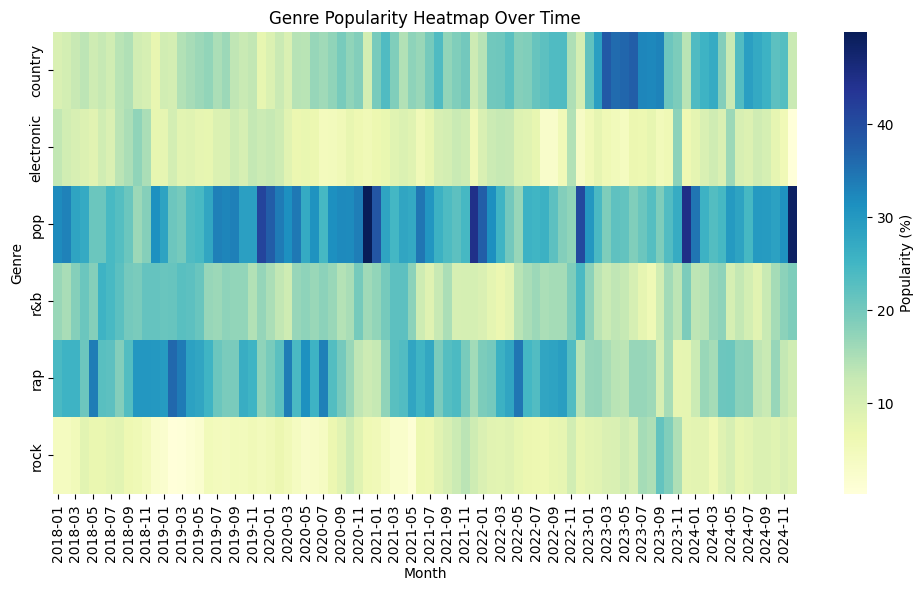

In [55]:
# Create a heatmap to identify trends

plt.figure(figsize=(12,6))
sns.heatmap(genre_popularity_pct_month.T, cmap='YlGnBu', cbar_kws={'label': 'Popularity (%)'})

ax = plt.gca()
ax.set_xticklabels([genre_popularity_pct_month.index[int(tick)].strftime('%Y-%m')
                    for tick in ax.get_xticks()])


plt.title("Genre Popularity Heatmap Over Time")
plt.xlabel("Month")
plt.ylabel("Genre")
plt.show()

primary_tag
electronic    43.973384
pop           44.319569
r&b           46.089908
rock          47.361472
rap           52.491104
country       60.416911
Name: rank, dtype: float64


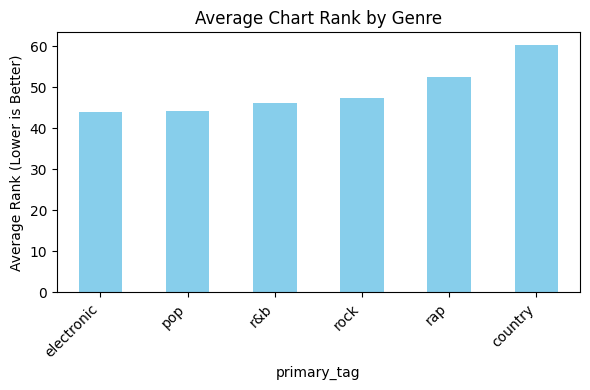

In [47]:
# Compute the average rank of genres
avg_rank = df.groupby('primary_tag')['rank'].mean().sort_values()
avg_rank = avg_rank.sort_values()
print(avg_rank)

# Visualization
plt.figure(figsize=(6,4))
avg_rank.plot(kind='bar', color='skyblue')
plt.ylabel('Average Rank')
plt.title('Average Chart Rank by Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Interpreation: Electronic music achieves on average the best ranks

primary_tag
pop           25.093858
country       23.044001
rap           22.368223
r&b           14.656855
electronic     7.899084
rock           6.937979
Name: proportion, dtype: float64


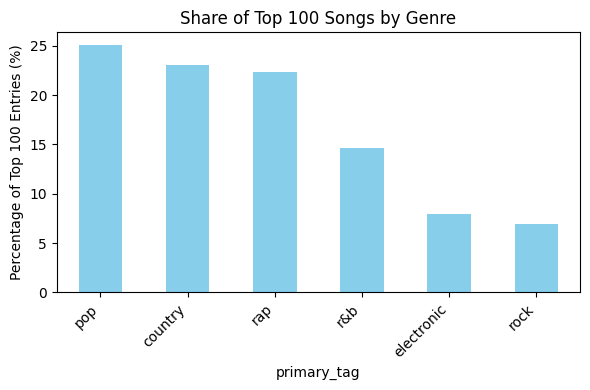

In [45]:
# Compute how many times a genre appears in the Top 100 relative to all entries
genre_counts = df['primary_tag'].value_counts(normalize=True) * 100
genre_counts = genre_counts.sort_values(ascending=False)
print(genre_counts)

# Visualization
plt.figure(figsize=(6,4))
genre_counts.plot(kind='bar', color='skyblue')
plt.ylabel('Percentage of Top 100 Entries (%)')
plt.title('Share of Top 100 Songs by Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Analysis of the persistance of songs in the charts:

In [56]:
# Compute how long songs stayed in the top 100

#song_weeks = df.groupby('genius_id')['chart_date'].nunique()

# for each song, count how many unique weeks it was present during that time
song_weeks = df.groupby(['title', 'artist'])['chart_date'].nunique()

# Convert to a DataFrame for easier handling
song_weeks_df = song_weeks.reset_index().rename(columns={'chart_date': 'weeks_in_top100'})
song_weeks_df = song_weeks_df.sort_values(by='weeks_in_top100', ascending=False)

song_weeks_df.head()

title         artist  weeks_in_top100
1137       Heat Waves  Glass Animals               91
340   Blinding Lights     The Weeknd               90
1527       Levitating       Dua Lipa               77
1591     Lose Control    Teddy Swims               71
2460           Snooze            SZA               70

Average weeks in Top 100 (all songs): 8.36


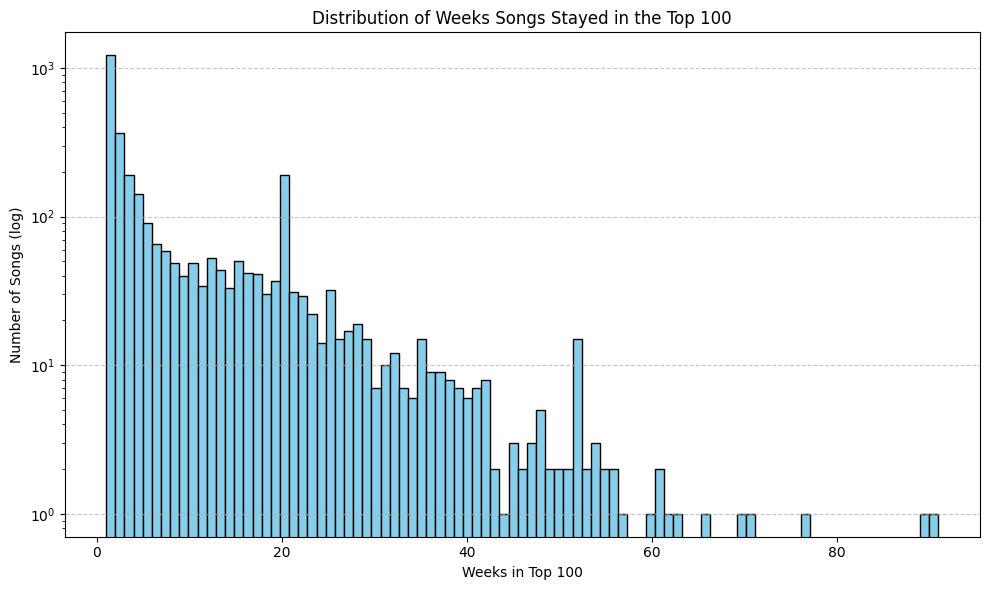

In [60]:
# Compute the average persistance of a song in the top 100 (over all genres)
avg_persistence_overall = song_weeks_df['weeks_in_top100'].mean()
print(f"Average weeks in Top 100 (all songs): {avg_persistence_overall:.2f}")

# Visualization of the average persistance
plt.figure(figsize=(10,6))
plt.hist(song_weeks_df['weeks_in_top100'], bins=91, color='skyblue', edgecolor='black')

plt.title("Distribution of Weeks Songs Stayed in the Top 100")
plt.xlabel("Weeks in Top 100")
plt.ylabel("Number of Songs (log)")
plt.yscale('log')  # Logarithmic scale for better visualization of the tail
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [61]:
# Add information regarding song persistance to the dataframe
song_persistance = pd.merge(df, song_weeks_df, on=['title', 'artist'])
song_persistance.head()

title                      artist  \
0              All I Want For Christmas Is You                Mariah Carey   
1  The Christmas Song (Merry Christmas To You)             Nat "King" Cole   
2                                  The Weekend                         SZA   
3                                     No Smoke  YoungBoy Never Broke Again   
4                                    New Rules                    Dua Lipa   

   genius_id primary_tag                                               tags  \
0     204233         r&b  [R&B, Pop, USA, In English, Soul Pop, Soul, Po...   
1    1717793         pop  [Pop, Big Band, Swing, Jazz, Acoustic, Holiday...   
2    3113598         r&b  [R&B, USA, In English, Psychedelic Soul, Neo S...   
3    3183597         rap                           [Rap, Dirty South, Trap]   
4    3013669  electronic  [Electronic, Pop, EDM, In English, UK Pop, Dan...   

  release_date                                              album  \
0   1994-10-29                                      Greatest Hits   
1         None  The Complete Capitol Recordings of The Nat Kin...   
2   2017-09-26                                      Ctrl (Deluxe)   
3   2017-08-03                                        AI YoungBoy   
4   2017-06-02                   Dua Lipa (Japan Special Edition)   

                                        lyrics_clean chart_date  rank  peak  \
0  want lot christmas one thing need care present... 2018-01-06    13   1.0   
1  chestnuts roasting open fire jack frost nippin... 2018-01-06    42   9.0   
2  mood right mood say got girl want want got gir... 2018-01-06    33   NaN   
3  dj chose bro bro nigga homie count money fuck ... 2018-01-06    77  61.0   
4  one talkin sleep night makin crazy wrote read ... 2018-01-06    12   6.0   

   peak_date  year      month   month_ts  song_length  rank_weight  \
0 2019-12-21  2018 2018-01-01 2018-01-01          150           88   
1 2023-01-07  2018 2018-01-01 2018-01-01           80           59   
2        NaT  2018 2018-01-01 2018-01-01          162           68   
3 2018-02-03  2018 2018-01-01 2018-01-01          233           24   
4 2018-02-17  2018 2018-01-01 2018-01-01          174           89   

   weeks_in_top100  
0               47  
1               37  
2                4  
3               15  
4               27

primary_tag
country       13.143469
pop           10.081448
rock           9.726316
electronic     9.392857
r&b            9.229314
rap            4.891626
Name: weeks_in_top100, dtype: float64
9.410838313908085


/tmp/ipython-input-1734290774.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




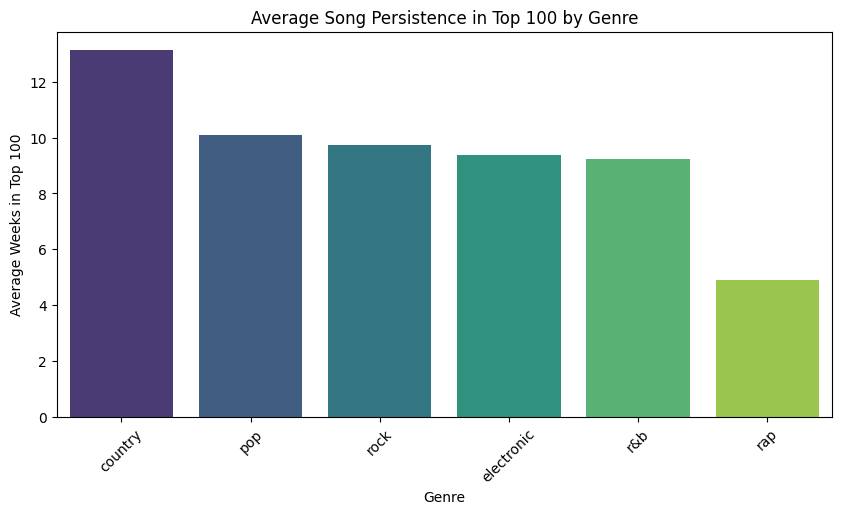

/tmp/ipython-input-1734290774.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




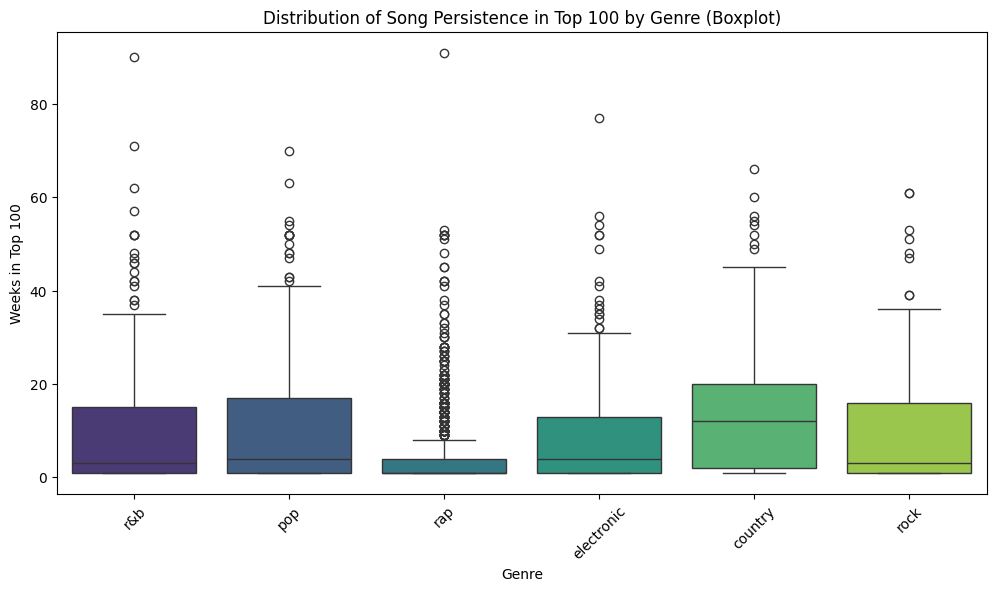

/tmp/ipython-input-1734290774.py:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




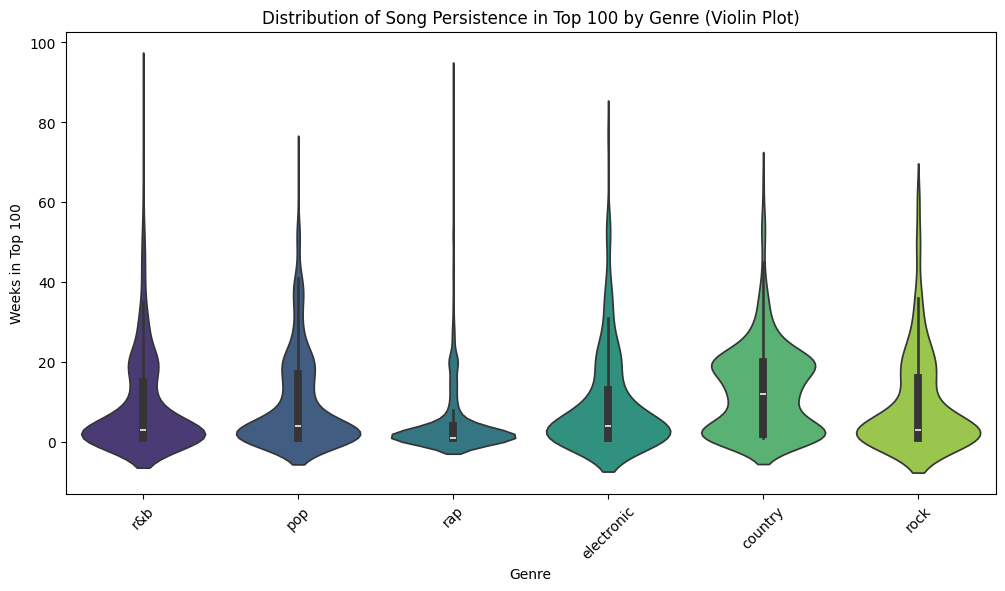

In [62]:
# Compute the average persistance of a song of a certain genre

# Only keep relevant information (how long a certain son (identified by title and artist) remained in the top 100)
unique_songs_genre = song_persistance[['title', 'artist', 'primary_tag', 'weeks_in_top100']].drop_duplicates()

# Compute average persistence per genre (group by genre)
avg_persistence_per_genre = unique_songs_genre.groupby('primary_tag')['weeks_in_top100'].mean().sort_values(ascending=False)
print(avg_persistence_per_genre)

print(avg_persistence_per_genre.mean())

# Visualization
plt.figure(figsize=(10,5))
sns.barplot(x=avg_persistence_per_genre.index, y=avg_persistence_per_genre.values, palette='viridis')
plt.ylabel('Average Weeks in Top 100')
plt.xlabel('Genre')
plt.title('Average Song Persistence in Top 100 by Genre')
plt.xticks(rotation=45)
plt.show()

# Boxplot
plt.figure(figsize=(12,6))
sns.boxplot(data=unique_songs_genre, x='primary_tag', y='weeks_in_top100', palette='viridis')
plt.ylabel('Weeks in Top 100')
plt.xlabel('Genre')
plt.title('Distribution of Song Persistence in Top 100 by Genre')
plt.xticks(rotation=45)
plt.show()

# Violin plot
plt.figure(figsize=(12,6))
sns.violinplot(data=unique_songs_genre, x='primary_tag', y='weeks_in_top100', palette='viridis')
plt.ylabel('Weeks in Top 100')
plt.xlabel('Genre')
plt.title('Distribution of Song Persistence in Top 100 by Genre')
plt.xticks(rotation=45)
plt.show()